In [3]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(crayon)
    library(tidyverse)
}))

# Definitions etc

In [1]:
set.seed(1234)
options(digits=2)
stats <- c()

In [2]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    prj_path = "/home/vsevim/prj/1012-ckd/S1/"
    data_subdir = "/analysis/primary/cellranger/Screen1_66guides_L1/outs/"
    souporcell_clusters_path = "/home/vsevim/prj/1012-ckd/S1/analysis/primary/souporcell/Lib_1/clusters.tsv"
    seurat_obj_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/Lib_1/seurat_objects/"
    seurat_obj_fname = "Screen1_66guides_Lib_1.h5seurat"

    library_name = "Lib_1"
    save_seurat_h5 = "NO"

    # prj_name    = "Screen2_101vecs"
    # prj_path    = "/home/vsevim/prj/1012-ckd/S2/"
    # data_subdir = "/analysis/primary/cellranger/Screen2_101vecs_1/outs/"
    # souporcell_clusters_path = "/home/vsevim/prj/1012-ckd/S2/analysis/primary/souporcell/Lib_1/clusters.tsv"
    # seurat_obj_path  = "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/Lib_1/seurat_objects/"
    # seurat_obj_fname = "Screen2_101vecs_Lib_1.h5seurat"

    # library_name = "Lib_1"
    # save_seurat_h5 = "NO"
}

In [4]:
data_path <- paste0(prj_path, data_subdir)
mx_path   <- paste0(data_path, "/filtered_feature_bc_matrix/")
h5_path   <- paste0(data_path, "/filtered_feature_bc_matrix.h5")
umi_thresholds_path <- paste0(data_path, "/crispr_analysis/protospacer_umi_thresholds.csv")
ps_calls_path <- paste0(data_path, "/crispr_analysis/protospacer_calls_per_cell.csv")
stats_out_path <- paste0(prj_path, "/analysis/primary/stats/")
save_h5_file <- paste0(seurat_obj_path, seurat_obj_fname)

In [5]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

In [6]:
data_path

[1] "/home/vsevim/prj/1012-ckd/S1//analysis/primary/cellranger/Screen1_66guides_L1/outs/"

In [7]:
if(!file.exists(souporcell_clusters_path)){    
    cat(souporcell_clusters_path, "DOES NOT EXIST!")
    stopifnot(FALSE)
}

### Load cell-cycle data

In [8]:
# A list of cell cycle markers, from Tirosh et al, 2015, is loaded with Seurat.  We can
# segregate this list into markers of G2/M phase and markers of S phase
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes


### Import demux counts from Cellranger

In [9]:
df_thresholds = read.csv(umi_thresholds_path)
df_ps_calls   = read.csv(ps_calls_path)

### Load 10x data

In [10]:
inputdata   <- Read10X_h5(h5_path)

Genome matrix has multiple modalities, returning a list of matrices for this genome



In [11]:
# extract RNA and sgRNA data
rna_counts   <- inputdata$`Gene Expression`
sgrna_counts <- inputdata$`CRISPR Guide Capture`

In [12]:
dim(rna_counts)
dim(sgrna_counts)

[1] 36601  9169

[1]  132 9169

In [13]:
n_cells_from_cellranger = ncol(rna_counts)
n_protospacers = nrow(sgrna_counts)
all_protospacer_ids = colnames(sgrna_counts)
n_genes = sum(rowSums(rna_counts) > 0)
cat(blue(prj_name, library_name), "\n")
cat(blue("#cells recovered:", n_cells_from_cellranger), "\n")
cat(blue("#genes recovered:", n_genes), "\n")
cat(blue("#protospacers in assay:", n_protospacers), "\n")

stats[["Screen"]]                = prj_name 
stats[["Library"]]               = library_name
stats[["Cells_recovered"]]       = n_cells_from_cellranger
stats[["Genes_recovered"]]       = n_genes
stats[["Protospacers_in_assay"]] = n_protospacers

Screen1_66guides Lib_1 
#cells recovered: 9169 
#genes recovered: 31847 
#protospacers in assay: 132 


# Visualize protospacer counts

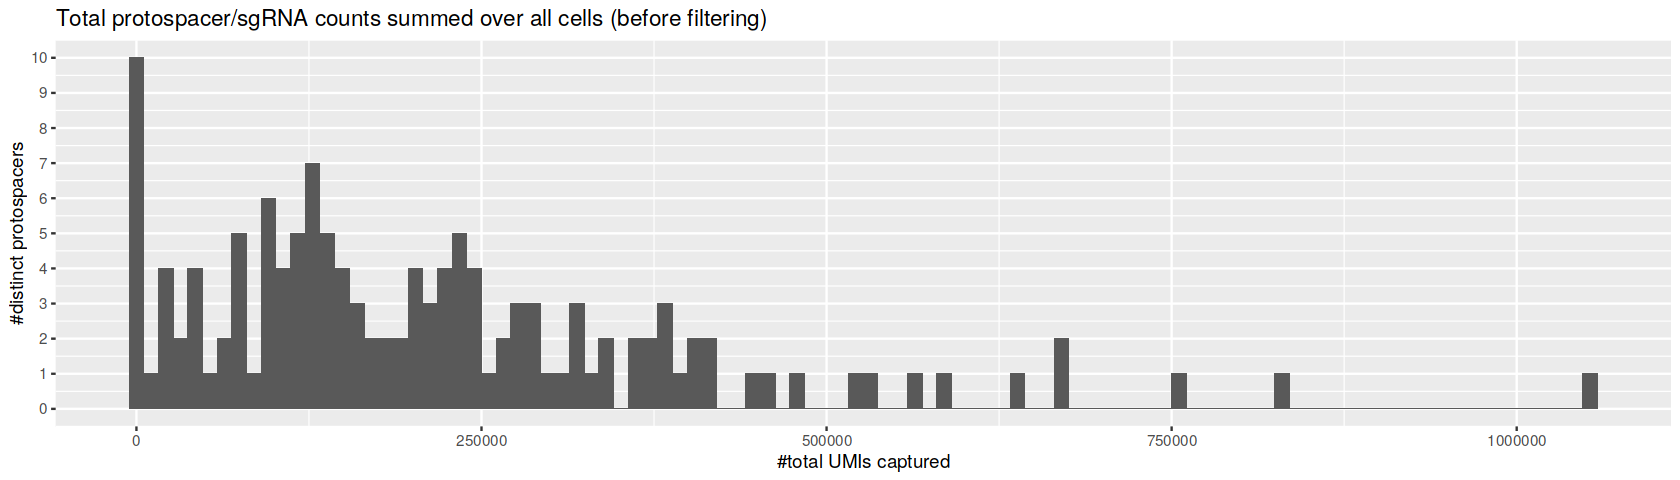

In [14]:
df_guide_counts = data.frame(total_guide_count=rowSums(sgrna_counts))
row.names(df_guide_counts) <- row.names(sgrna_counts)

options(repr.plot.width=14, repr.plot.height=4)
ggplot(df_guide_counts, aes(x = total_guide_count)) +
    geom_histogram(bins=100) +
    labs(title = "Total protospacer/sgRNA counts summed over all cells (before filtering)", x = "#total UMIs captured") +
    labs(y = "#distinct protospacers") +
    scale_y_continuous(breaks=seq(0,10, by=1))


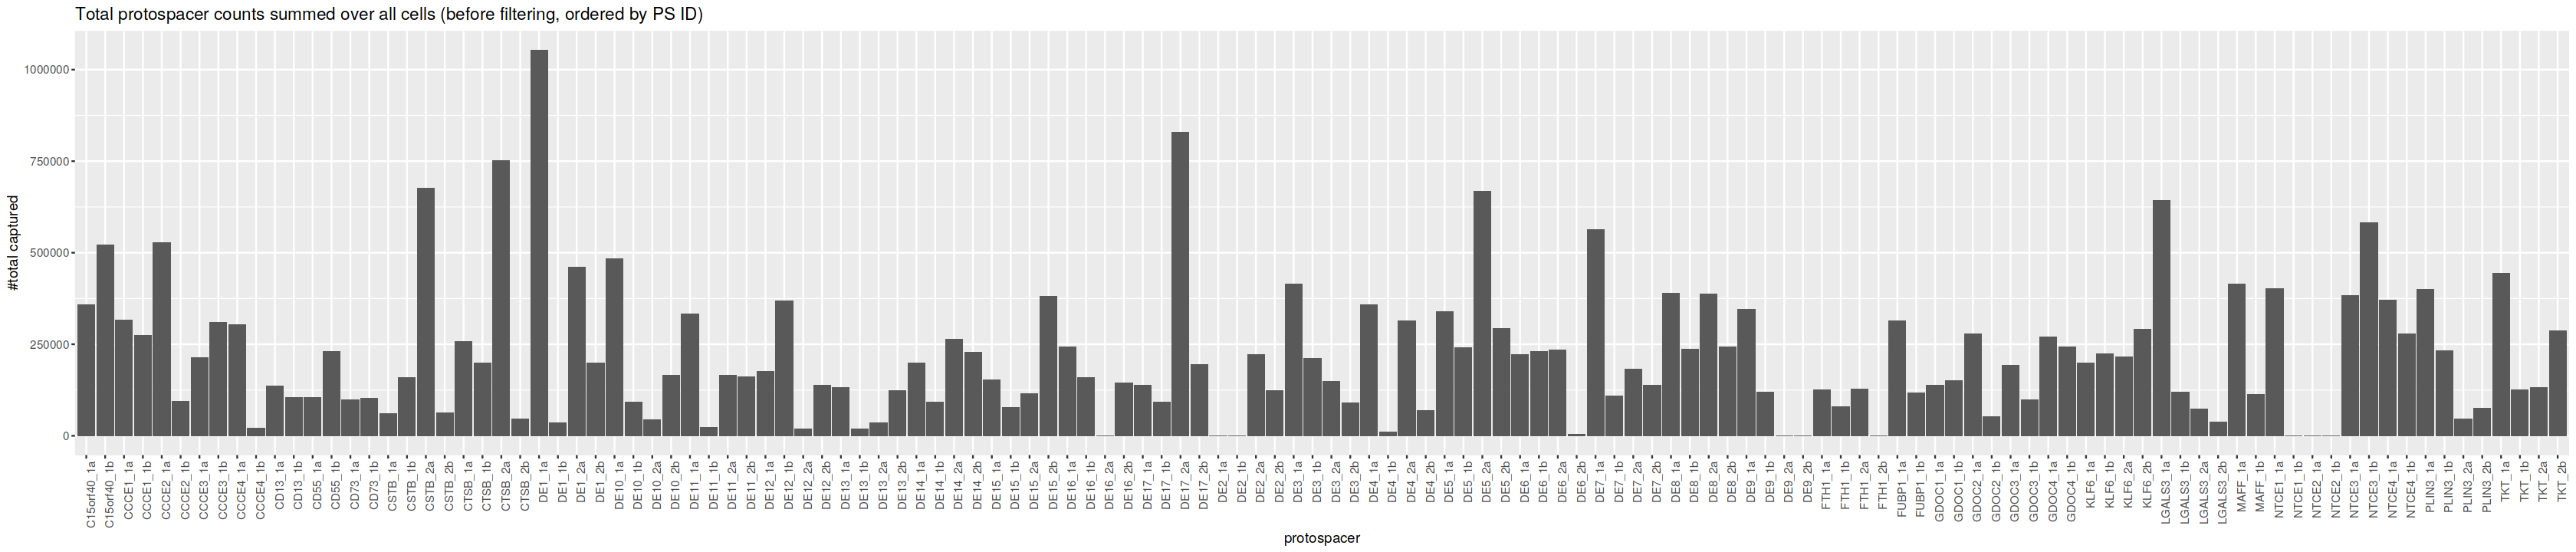

In [15]:
df_guide_counts_ordered <- df_guide_counts[order(df_guide_counts$total_guide_count),,drop=FALSE]
df_guide_counts_ordered$protospacer  <- rownames(df_guide_counts_ordered)

options(repr.plot.width=28, repr.plot.height=6)
ggplot(df_guide_counts_ordered, aes(x=protospacer, y=total_guide_count)) +
    geom_bar(stat='identity') + 
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(title = "Total protospacer counts summed over all cells (before filtering, ordered by PS ID)", x = "protospacer") +
    labs(y = "#total captured") 

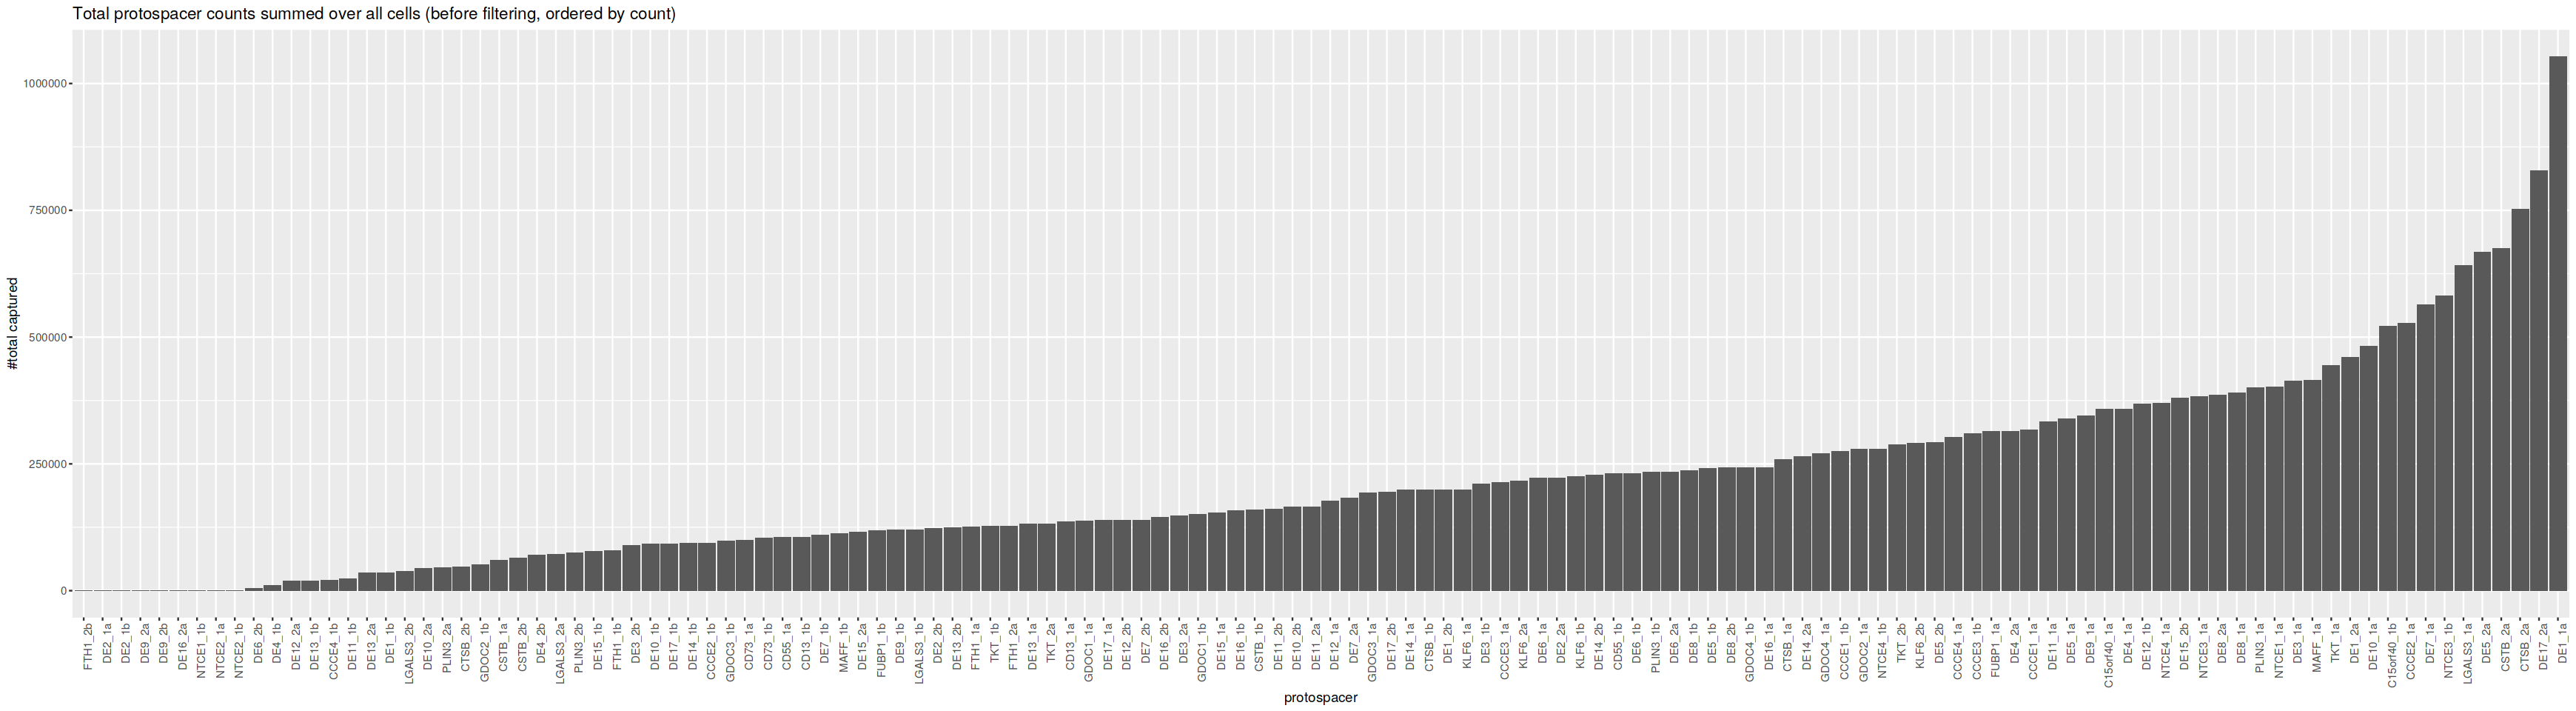

In [16]:
df_guide_counts_ordered$protospacer <- factor(df_guide_counts_ordered$protospacer, levels = df_guide_counts_ordered$protospacer)

options(repr.plot.width=29, repr.plot.height=8)
ggplot(df_guide_counts_ordered, aes(x=protospacer, y=total_guide_count)) +
    geom_bar(stat='identity') + 
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(title = "Total protospacer counts summed over all cells (before filtering, ordered by count)", x = "protospacer") +
    labs(y = "#total captured") 

In [17]:
head(df_guide_counts_ordered,10)

total_guide_count protospacer
FTH1_2b     0              FTH1_2b    
DE2_1a      0              DE2_1a     
DE2_1b      0              DE2_1b     
DE9_2a      0              DE9_2a     
DE9_2b      0              DE9_2b     
DE16_2a     0              DE16_2a    
NTCE1_1b    0              NTCE1_1b   
NTCE2_1a    0              NTCE2_1a   
NTCE2_1b    0              NTCE2_1b   
DE6_2b   4074              DE6_2b

### Create Seurat object

In [18]:
seurat_unfiltered <- CreateSeuratObject(counts = rna_counts, project = prj_name)
sgrna_assay       <- CreateAssayObject(counts = sgrna_counts)
seurat_unfiltered[["sgRNA"]] <- sgrna_assay
seurat_unfiltered$library = library_name

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


### Get mitochondrial content

In [19]:
seurat_unfiltered[["percent.mt"]] <-
    PercentageFeatureSet(seurat_unfiltered, pattern = "^MT-")

In [20]:
DefaultAssay(seurat_unfiltered) <- "RNA"

## QC

### Get RNA counts per cell

In [21]:
counts_per_cell <- Matrix::colSums(rna_counts)
cat("counts per cell: ", counts_per_cell[1:20], "\n") ## counts for first 5 cells

counts per cell:  25177 126284 43882 72819 63548 34134 58713 39586 41292 34276 85917 24140 52964 60166 44031 90062 42192 9360 53193 60136 


In [22]:
counts_per_gene <- Matrix::rowSums(rna_counts)
cat("counts per gene: ", counts_per_gene[1:20], "\n")  

counts per gene:  3 0 4 157 9 0 223 3 0 2 0 1 0 3 2711 4 3178 148 465 115 


In [23]:
genes_per_cell  <- Matrix::colSums(rna_counts > 0)       # count gene only if it has non-zero reads mapped.
guides_per_cell <- Matrix::colSums(sgrna_counts > 0)     # count gene only if it has non-zero reads mapped.

cat("counts for non-zero genes: ", genes_per_cell[1:5], "\n")  # counts for first 5 genes
cat("counts for non-zero guides:", guides_per_cell[1:5], "\n")  # counts for first 5 genes

counts for non-zero genes:  5887 11066 7417 9098 8607 
counts for non-zero guides: 19 28 31 22 20 


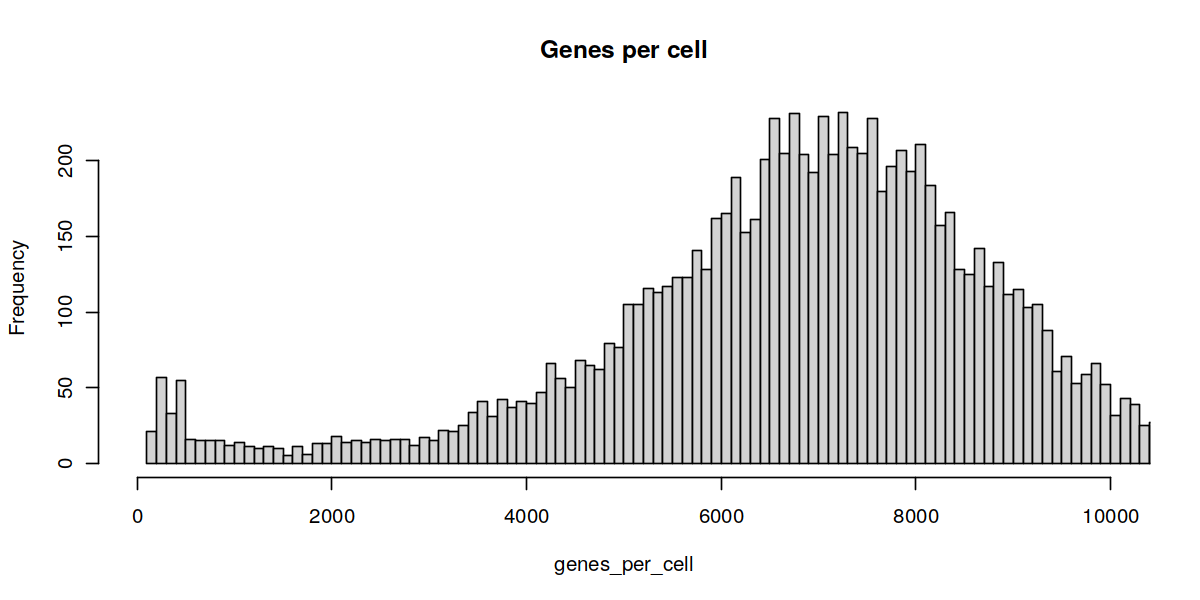

In [24]:
options(repr.plot.width=10, repr.plot.height=5)
#plot_log <- hist(log10(genes_per_cell), main="Genes per cell", breaks=100)
plot_lin <- hist(genes_per_cell, main="Genes per cell", breaks=100, xlim=c(1,10000))
#plot_guide_counts <- hist(guides_per_cell, main="Distinct protospacers per cell", breaks=100, xlim=c(1,100))

### --

### Plot RNA counts per cell 

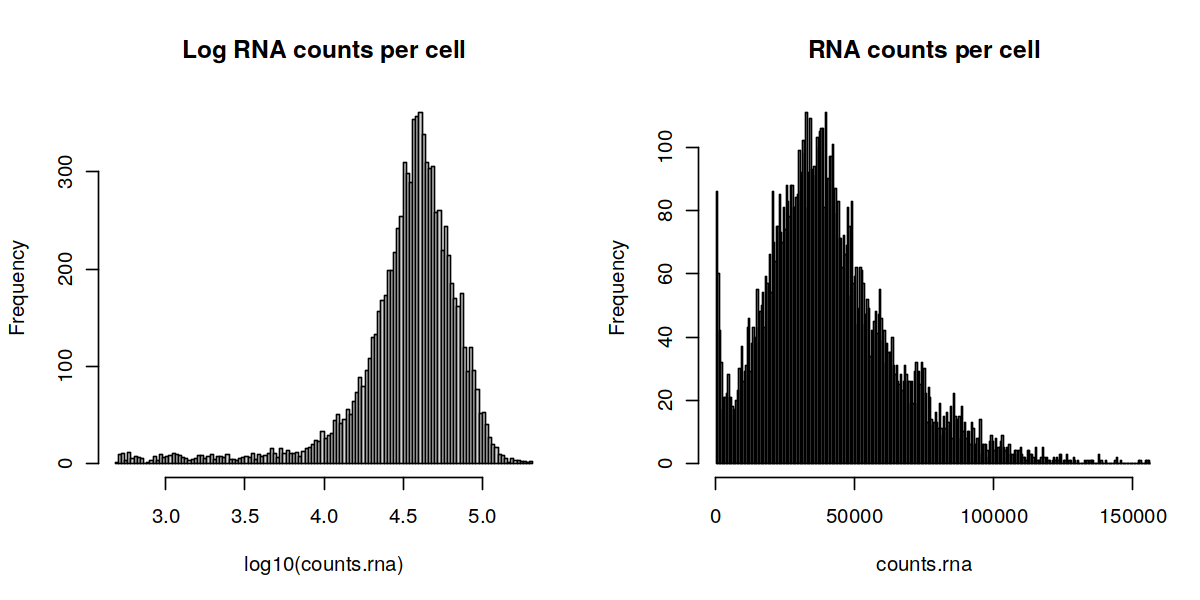

In [25]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
counts.rna <- seurat_unfiltered@meta.data$nCount_RNA
plot_log    <- hist(log10(counts.rna), main="Log RNA counts per cell", breaks=100)
plot_lin    <- hist(counts.rna, main="RNA counts per cell", breaks=500, xlim=c(1,150000))

### Plot sgRNA counts per cell 

In [26]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
counts.sgrna <- seurat_unfiltered@meta.data$nCount_sgRNA
plot_log    <- hist(log10(counts.sgrna), main="Log sgRNA counts per cell", breaks=100)
plot_lin    <- hist(counts.sgrna, main="sgRNA counts per cell", breaks=500, xlim=c(1,150000))

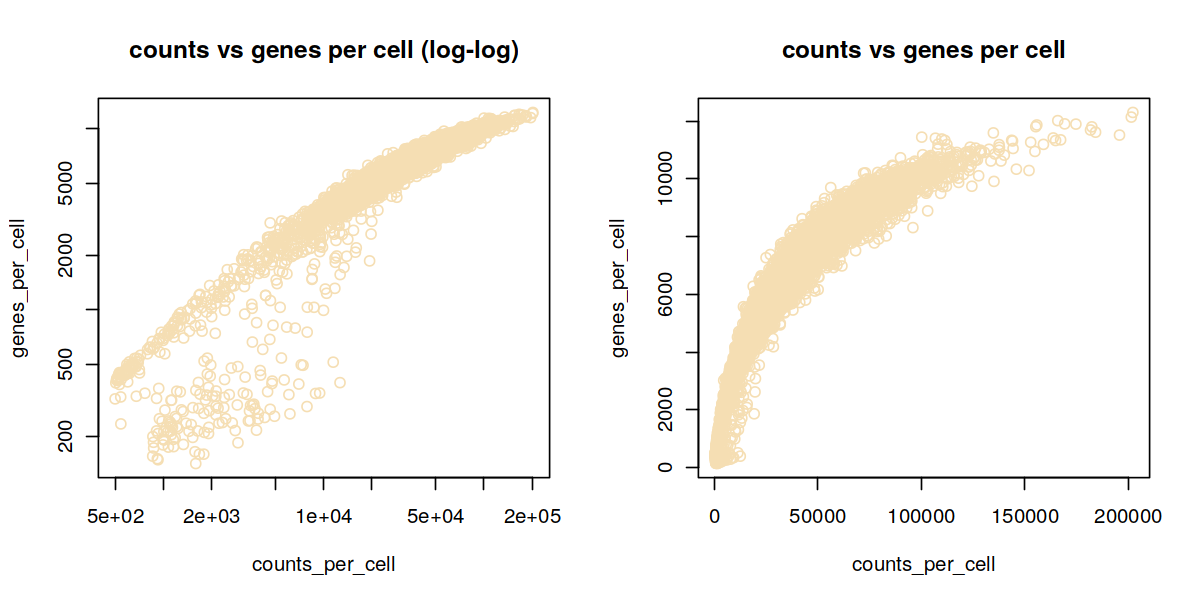

In [27]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
plot(counts_per_cell, genes_per_cell, log='xy', col='wheat')
title('counts vs genes per cell (log-log)')
plot(counts_per_cell, genes_per_cell, col='wheat')
title('counts vs genes per cell')

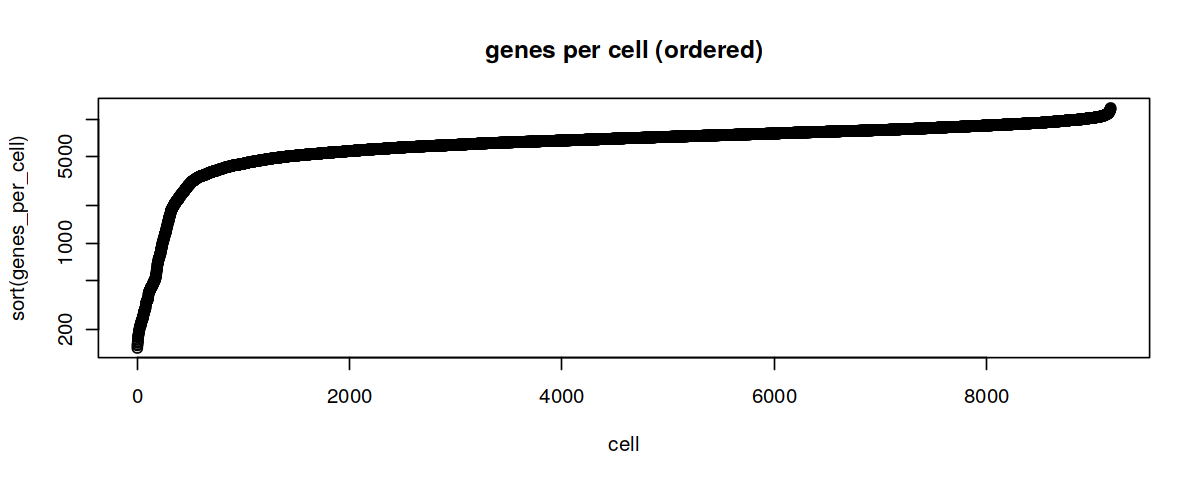

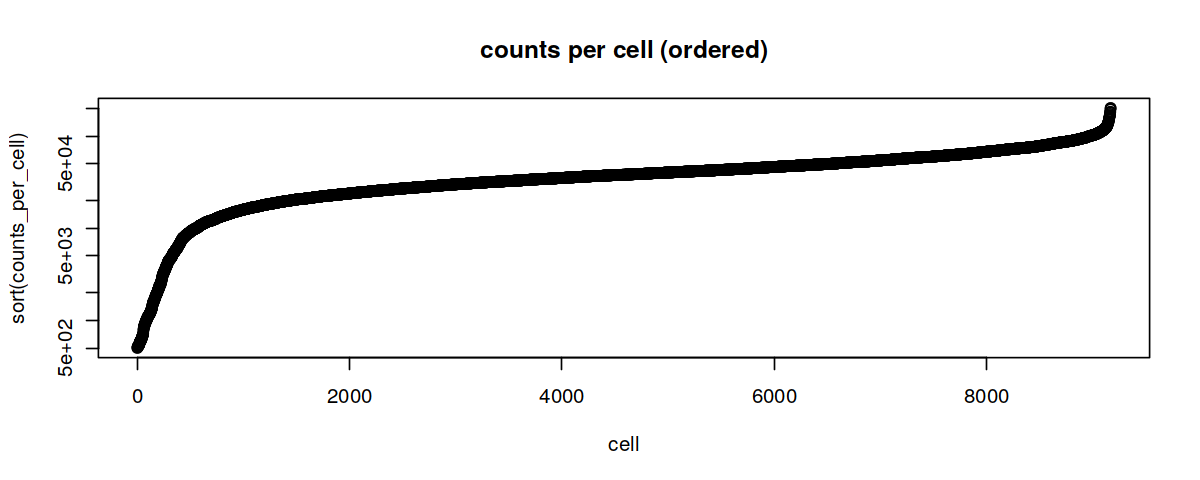

In [28]:
options(repr.plot.width=10, repr.plot.height=4)
plot(sort(genes_per_cell), xlab='cell', log='y', main='genes per cell (ordered)')
plot(sort(counts_per_cell), xlab='cell', log='y', main='counts per cell (ordered)')

In [29]:
#FeatureScatter(object = seurat_unfiltered, feature1 = "nCount_RNA", feature2 = "nCount_ATAC", log)

### QC using houskeeping genes

In [30]:
# Load the the list of house keeping genes
hkgenes <- read.table("/home/vsevim/prj/tf/tf1/data/QC/housekeeping.txt", skip = 2)
hkgenes <- as.vector(hkgenes$V1)

In [31]:
# remove hkgenes that were not found
hkgenes.found <- which(toupper(rownames(seurat_unfiltered@assays$RNA@data)) %in% hkgenes)

In [32]:
num_hk_genes = length(hkgenes.found)
num_hk_genes

[1] 95

In [33]:
n.expressed.hkgenes <- Matrix::colSums(seurat_unfiltered@assays$RNA@data[hkgenes.found, ] > 0)

In [34]:
options(repr.plot.width=6, repr.plot.height=4)
df.expressed.hk <- data.frame(100*n.expressed.hkgenes/num_hk_genes)
ggplot(df.expressed.hk, aes(n.expressed.hkgenes)) + geom_histogram(binwidth=1) + labs(x="%expressed housekeeping genes in cell")

### QC by mitochondrial genes

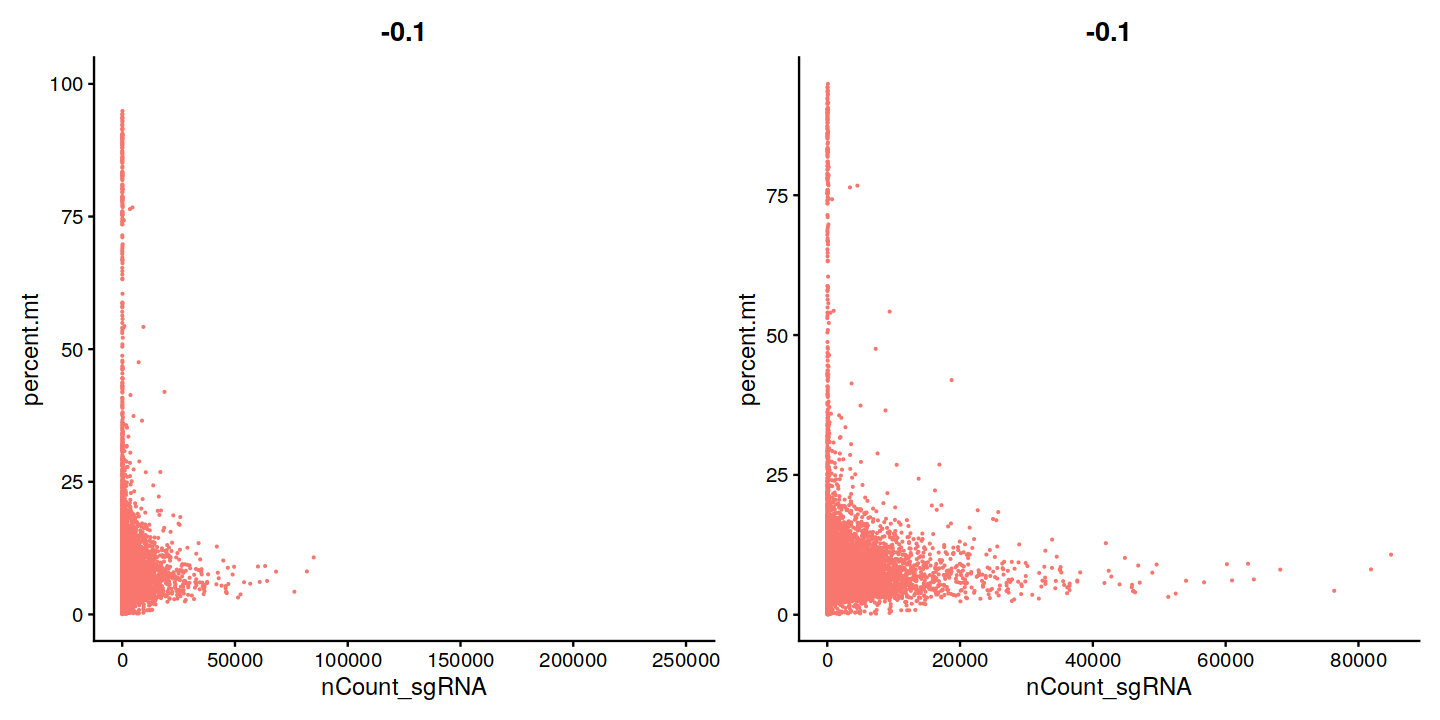

In [35]:
options(repr.plot.width=12, repr.plot.height=6)
plot1 <- FeatureScatter(seurat_unfiltered, feature1 = "nCount_sgRNA", feature2 = "percent.mt", pt.size=.1)
plot1 + xlim(c(0,250000)) + ylim(c(0,100)) + NoLegend() | plot1 + NoLegend()

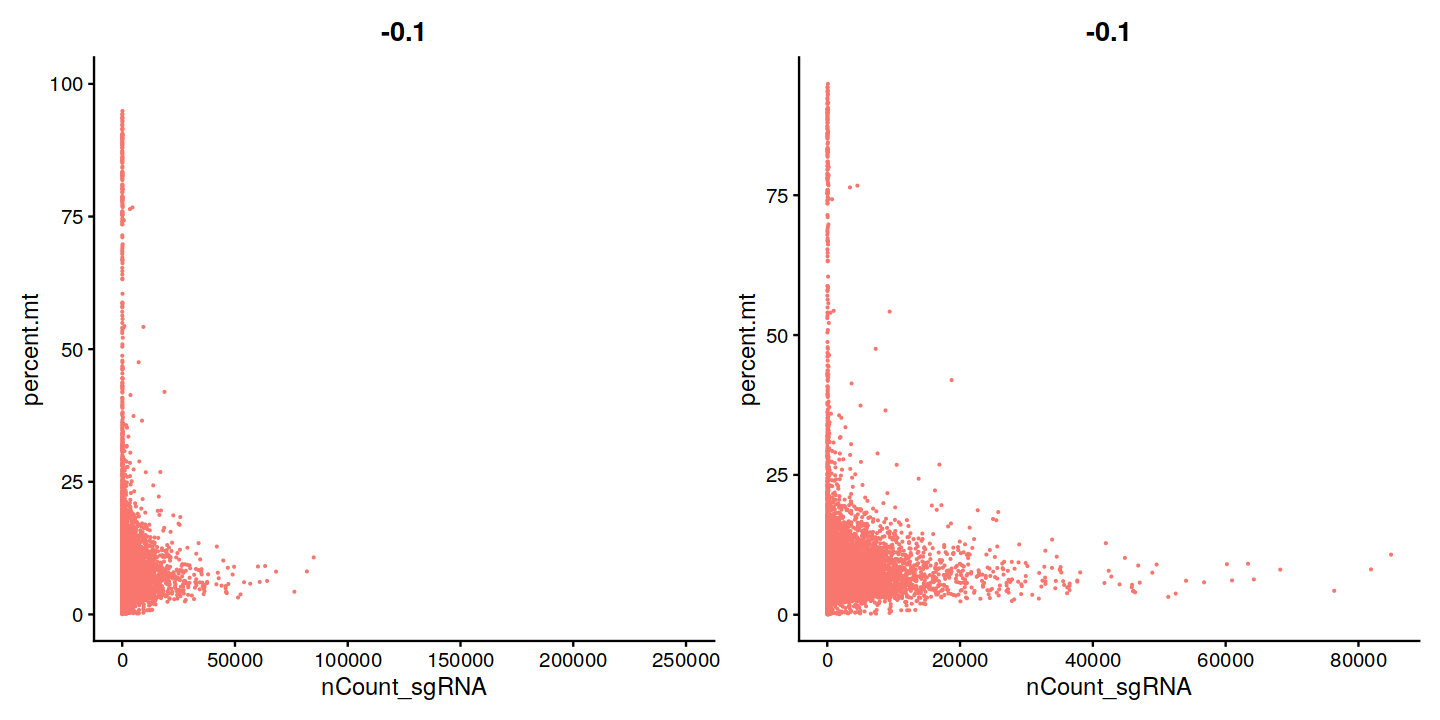

In [36]:
options(repr.plot.width=12, repr.plot.height=6)
plot1 <- FeatureScatter(seurat_unfiltered, feature1 = "nCount_sgRNA", feature2 = "percent.mt", pt.size=.1)
plot1 + xlim(c(0,250000)) + ylim(c(0,100)) + NoLegend() | plot1 + NoLegend()

## Filtering

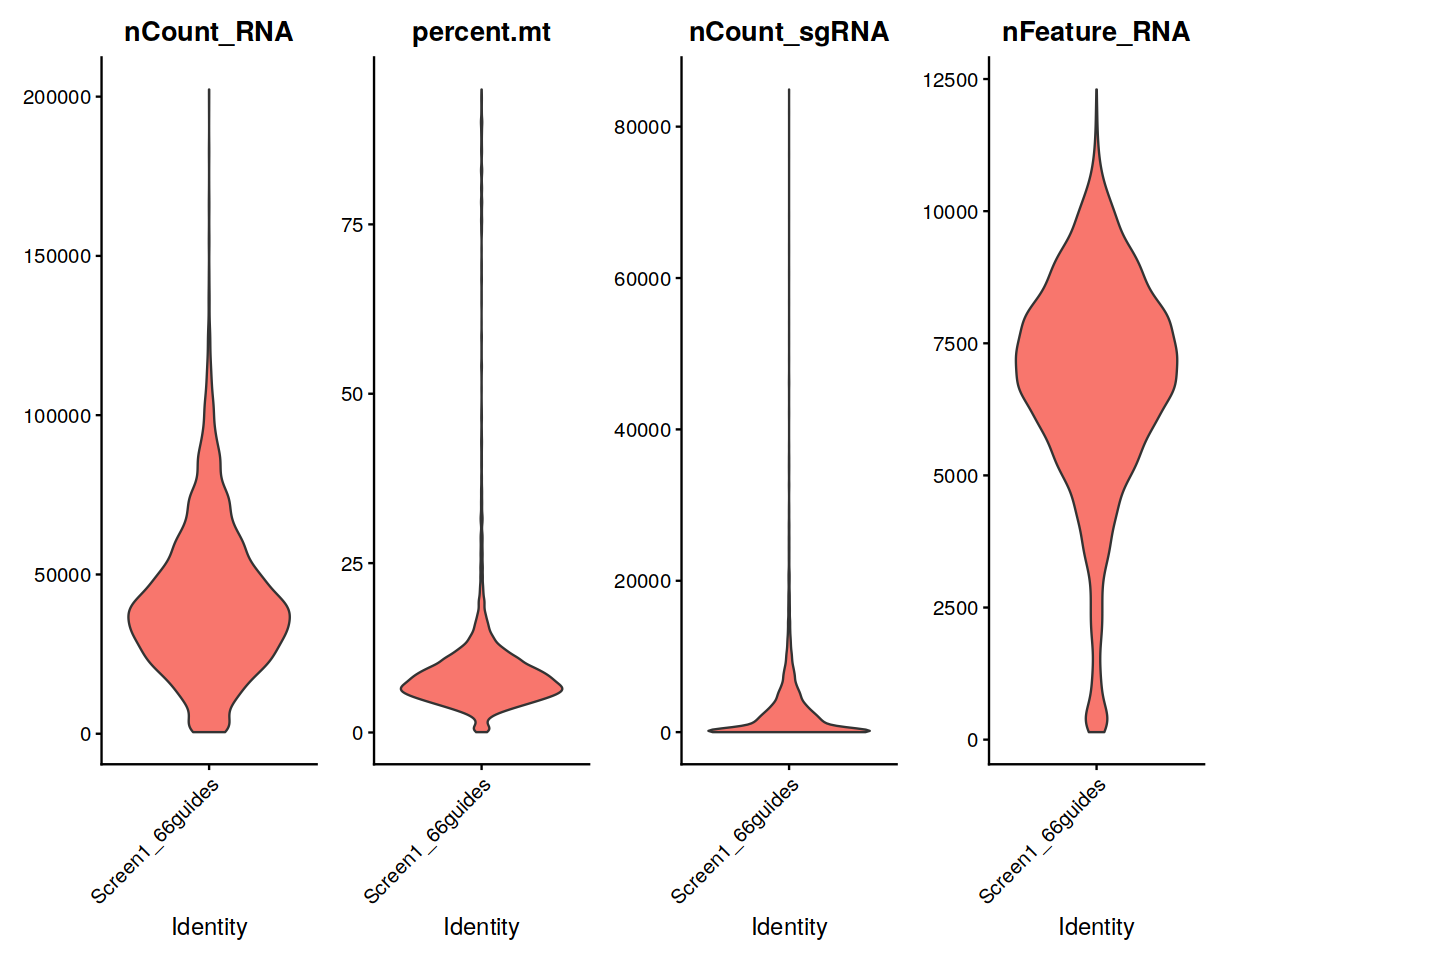

In [37]:
options(repr.plot.width=12, repr.plot.height=8)

VlnPlot(
  object = seurat_unfiltered,
  features = c("nCount_RNA", "percent.mt", "nCount_sgRNA", "nFeature_RNA"),
  ncol = 5,
  log=FALSE,
  pt.size = 0
)

VlnPlot(
  object = seurat_unfiltered,
  features = c("nCount_RNA", "percent.mt", "nCount_sgRNA", "nFeature_RNA"),
  ncol = 5,
  log=TRUE,
  pt.size = 0
)

### Filter out low quality cells

In [38]:
mads = 3

desired_max_mito <- median(seurat_unfiltered$percent.mt) + mads*mad(seurat_unfiltered$percent.mt)
desired_min_mito <- median(seurat_unfiltered$percent.mt) - mads*mad(seurat_unfiltered$percent.mt)
desired_min_mito <- max(desired_min_mito, 3)

desired_max_rna <- median(seurat_unfiltered$nCount_RNA) + mads*mad(seurat_unfiltered$nCount_RNA)
desired_min_rna <- median(seurat_unfiltered$nCount_RNA) - mads*mad(seurat_unfiltered$nCount_RNA)

desired_max_genes <- median(seurat_unfiltered$nFeature_RNA) + mads*mad(seurat_unfiltered$nFeature_RNA)
desired_min_genes <- median(seurat_unfiltered$nFeature_RNA) - mads*mad(seurat_unfiltered$nFeature_RNA)

In [39]:
stats[["Max_mito_perc_threshold"]] = desired_max_mito
stats[["Min_mito_perc_threshold"]] = desired_min_mito

stats[["Max_n_RNA_threshold"]] = desired_max_rna
stats[["Min_n_RNA_threshold"]] = desired_min_rna

stats[["Max_n_genes_threshold"]] = desired_max_genes
stats[["Min_n_genes_threshold"]] = desired_min_genes

In [40]:
for(stat in names(stats)){
    cat(blue(stat), ":", stats[[stat]], "\n")
}

Screen : Screen1_66guides 
Library : Lib_1 
Cells_recovered : 9169 
Genes_recovered : 31847 
Protospacers_in_assay : 132 
Max_mito_perc_threshold : 17 
Min_mito_perc_threshold : 3 
Max_n_RNA_threshold : 98264 
Min_n_RNA_threshold : -22058 
Max_n_genes_threshold : 12173 
Min_n_genes_threshold : 1837 


In [42]:
seurat <- subset(
  x = seurat_unfiltered,
  subset = 
    nCount_RNA < desired_max_rna &
    nCount_RNA > desired_min_rna &
    percent.mt < desired_max_mito & 
    percent.mt > desired_min_mito &
    nFeature_RNA < desired_max_genes &
    nFeature_RNA > desired_min_genes 
)

In [42]:
stats[["Cells_after_QC_filtering"]] <- length(Cells(seurat))
stats[["Cells_with_sgRNA_count_less_than_100"]] <- length(Cells(subset(x = seurat, subset = nCount_sgRNA < 100)))

In [43]:
nrow(seurat_unfiltered@meta.data)
nrow(seurat@meta.data)

[1] 9169

[1] 8015

In [44]:
options(repr.plot.width=14, repr.plot.height=10)
VlnPlot(seurat, 
        features = c("nCount_RNA", "percent.mt", "nCount_sgRNA", "nFeature_RNA"), 
        ncol = 4, 
        log = TRUE, 
        pt.size = .01)

In [45]:
remaining_cells <- nrow(seurat@meta.data)
remaining_cells

[1] 8015

### Import demux counts from Cellranger

In [46]:
df_thresholds = read.csv(umi_thresholds_path)
df_ps_calls   = read.csv(ps_calls_path)

In [47]:
guide_calls_list         = list()
construct_calls_list     = vector()
target_calls_list          = list() 
num_construct_calls_list = list()
num_guide_calls_list     = list()

for(call in df_ps_calls$feature_call) {
    calls <- strsplit(call, "\\|")[[1]]
    guide_calls <- calls
    
    calls <- gsub("_1.", "_1", calls)
    calls <- gsub("_2.", "_2", calls)
    calls <- unique(calls)
    target_calls <- paste(unique(gsub("_[0-9]*", "", calls)), collapse = "|")

    target_calls_list        <- c(target_calls_list, target_calls)
    construct_calls_list     <- c(construct_calls_list, paste(calls, collapse = "|"))
    num_construct_calls_list <- c(num_construct_calls_list, length(calls))
    guide_calls_list         <- c(guide_calls_list, list(guide_calls))
    num_guide_calls_list     <- c(num_guide_calls_list, length(guide_calls))
}
df_ps_calls$construct_call        <- as.factor(as.character(construct_calls_list))
df_ps_calls$num_called_constructs <- num_construct_calls_list
df_ps_calls$PS_call               <- guide_calls_list
df_ps_calls$num_PS_call           <- num_guide_calls_list
df_ps_calls$target_call           <- as.character(target_calls_list)

In [48]:
head(calls, 10)
head(target_calls)

[1] "TKT_2"    "LGALS3_1" "KLF6_2"   "DE8_1"    "DE9_1"    "DE12_1"   "DE17_1"  
[8] "NTCE4_1"  "CCCE1_1"

[1] "TKT|LGALS3|KLF6|DE8|DE9|DE12|DE17|NTCE4|CCCE1"

In [49]:
head(seurat_unfiltered)

orig.ident       nCount_RNA nFeature_RNA nCount_sgRNA
AAACCCAAGAGCAGCT-1 Screen1_66guides  25177      5887         3237       
AAACCCAAGCCGGAAT-1 Screen1_66guides 126284     11066         5755       
AAACCCAAGCTTAAGA-1 Screen1_66guides  43882      7417         2844       
AAACCCAAGGCTGTAG-1 Screen1_66guides  72819      9098         1908       
AAACCCAAGGTTTACC-1 Screen1_66guides  63548      8607         2088       
AAACCCAAGTGATCGG-1 Screen1_66guides  34134      6638            7       
AAACCCACATTCGATG-1 Screen1_66guides  58713      9054         7236       
AAACGAACAATTGCTG-1 Screen1_66guides  39586      7315         1343       
AAACGAACAGGTGAGT-1 Screen1_66guides  41292      7781        15272       
AAACGAACATGGCTGC-1 Screen1_66guides  34276      7318         1328       
                   nFeature_sgRNA library percent.mt
AAACCCAAGAGCAGCT-1 19             Lib_1    6.7      
AAACCCAAGCCGGAAT-1 28             Lib_1   11.6      
AAACCCAAGCTTAAGA-1 31             Lib_1    9.0      
AAACCCAAGGCTGTAG-1 22             Lib_1   14.1      
AAACCCAAGGTTTACC-1 20             Lib_1    6.2      
AAACCCAAGTGATCGG-1  7             Lib_1   15.6      
AAACCCACATTCGATG-1 42             Lib_1    7.0      
AAACGAACAATTGCTG-1 17             Lib_1    5.6      
AAACGAACAGGTGAGT-1 77             Lib_1    5.2      
AAACGAACATGGCTGC-1 14             Lib_1    3.6

<font color='red'>Keep only the cells with PS calls from Cellranger (skip this if you switch to another demux algo)</font> !!!!


In [50]:
cells_w_PS_calls <- df_ps_calls$cell_barcode
#seurat <- subset(seurat, cells = cells_w_PS_calls)
stats[["Cells_with_a_guide_assigned_by_Cellranger_caller"]] <- length(Cells(seurat))

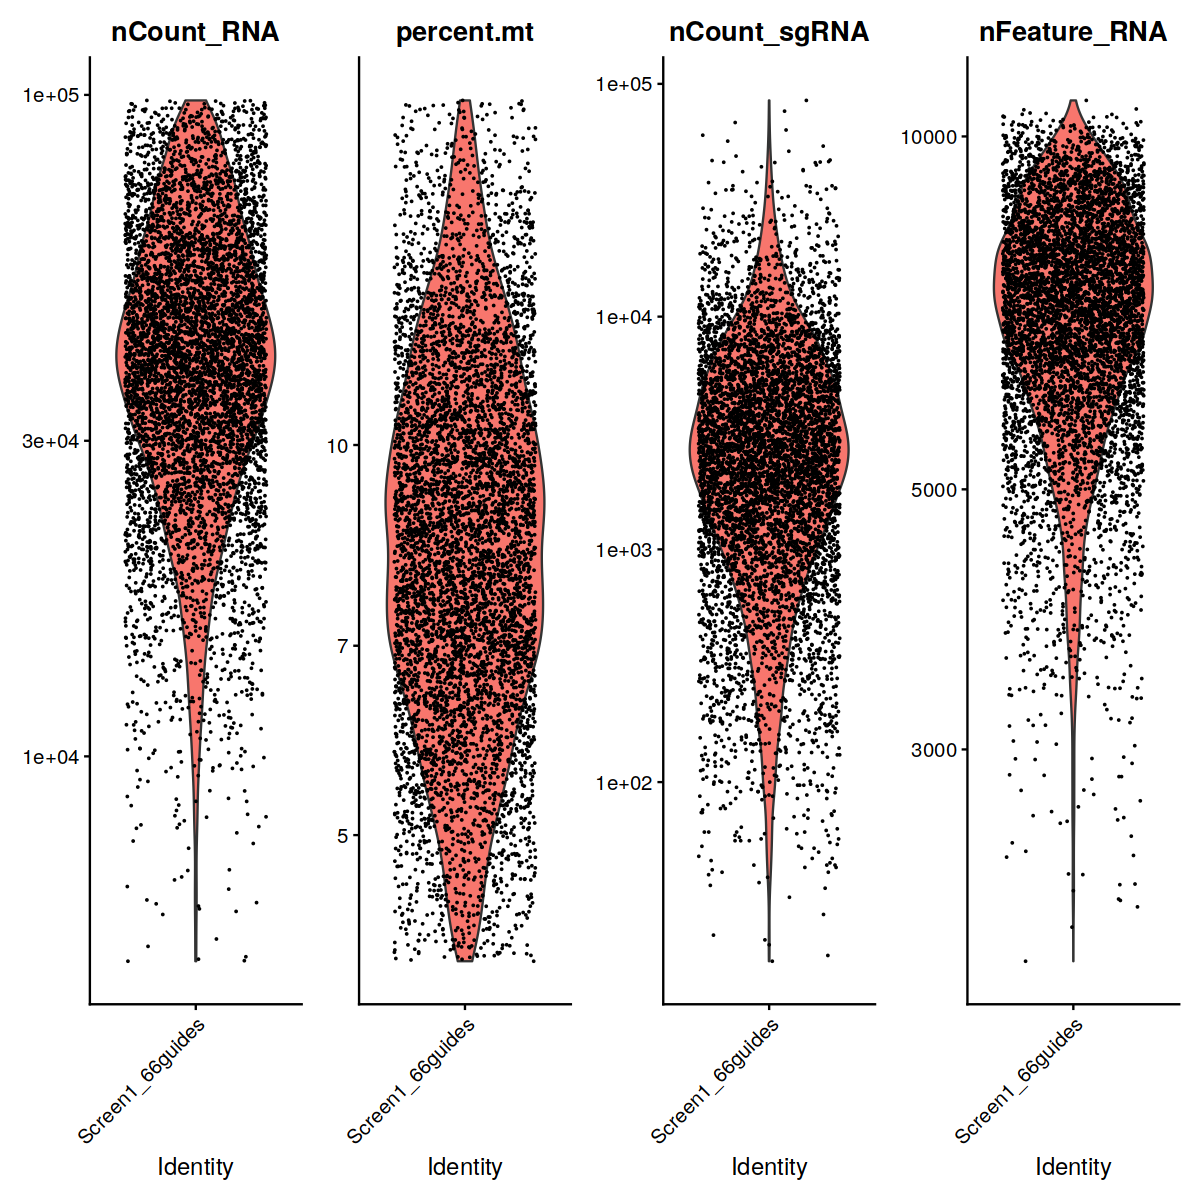

In [50]:
options(repr.plot.width=10, repr.plot.height=10)
VlnPlot(seurat, 
        features = c("nCount_RNA", "percent.mt", "nCount_sgRNA", "nFeature_RNA"), 
        ncol = 4, 
        log = TRUE, 
        pt.size = .01)

In [51]:
my_cells = Cells(seurat)
rownames(df_ps_calls) <- df_ps_calls$cell_barcode

df_ps_calls_ordered_by_barcodes = df_ps_calls[my_cells,]

seurat@meta.data$PS_call            <- as.factor(df_ps_calls_ordered_by_barcodes$feature_call)
seurat@meta.data$construct_call     <- as.factor(df_ps_calls_ordered_by_barcodes$construct_call)
seurat@meta.data$target_call        <- as.factor(df_ps_calls_ordered_by_barcodes$target_call)
seurat@meta.data$nCalled_Constructs <- as.integer(df_ps_calls_ordered_by_barcodes$num_called_constructs)
seurat@meta.data$nPS_calls          <- as.integer(df_ps_calls_ordered_by_barcodes$num_PS_call)
seurat@meta.data$nCalled_sgRNA_UMIs <- df_ps_calls_ordered_by_barcodes$num_umis

In [52]:
head(seurat, 3)

orig.ident       nCount_RNA nFeature_RNA nCount_sgRNA
AGCTCAATCGTAGGGA-1 Screen1_66guides 32644      5712           92        
CAACAGTTCCTAGCGG-1 Screen1_66guides 40788      6939         1412        
AAACGCTCAGTTAGAA-1 Screen1_66guides 44827      7247         3081        
                   nFeature_sgRNA library percent.mt PS_call                
AGCTCAATCGTAGGGA-1  9             Lib_1   4.8        C15orf40_1a            
CAACAGTTCCTAGCGG-1 23             Lib_1   6.4        C15orf40_1a            
AAACGCTCAGTTAGAA-1 27             Lib_1   9.7        C15orf40_1a|C15orf40_1b
                   construct_call target_call nCalled_Constructs nPS_calls
AGCTCAATCGTAGGGA-1 C15orf40_1     C15orf40    1                  1        
CAACAGTTCCTAGCGG-1 C15orf40_1     C15orf40    1                  1        
AAACGCTCAGTTAGAA-1 C15orf40_1     C15orf40    1                  2        
                   nCalled_sgRNA_UMIs
AGCTCAATCGTAGGGA-1 57                
CAACAGTTCCTAGCGG-1 1383              
AAACGCTCAGTTAGAA-1 1302|1753

## Normalization, PCA, UMAP, SVD

### Normalize RNA assay

In [53]:
DefaultAssay(seurat) <- "RNA"
seurat <- SCTransform(
    seurat, 
    method = "glmGamPoi", 
    vst.flavor = "v2", 
    verbose = FALSE
)  %>% 
    RunPCA() %>% 
    RunUMAP(dims = 1:40, reduction.name = 'umap.rna', reduction.key = 'rnaUMAP_', verbose=FALSE)
 
#RunPCA(features = c(s.genes, g2m.genes)) %>% 
#vars.to.regress = c('S.Score', 'G2M.Score')
#vars.to.regress = "percent.mt", 


PC_ 1 
Positive:  ERBB4, KCNIP4, MECOM, FAM155A, WFDC2, AC019197.1, MAL, PDE1A, BST2, KITLG 
	   PKHD1, SFRP1, SKAP1, SNED1, BICC1, ACSL4, DENND2A, TFAP2B, LRP1B, TFCP2L1 
	   SGIP1, HOXB3, SIM1, SCN2A, GPNMB, ARHGEF38, S100A2, PANTR1, SPON1, CSGALNACT1 
Negative:  FTL, CRYAB, MT1X, APOE, SOD2, PLIN2, S100A1, FTH1, MT1E, G0S2 
	   SERPINA1, FN1, MGST1, CTSB, SERPINE1, NUPR1, RRAD, RARRES2, ITPKA, GPX3 
	   MT2A, VGF, FGB, PDZK1IP1, IL32, AKR1C3, SAA1, VCAM1, SQSTM1, TFPI2 
PC_ 2 
Positive:  CENPF, TUBA1B, MKI67, TOP2A, HMGB2, TPX2, PCLAF, ASPM, DLGAP5, CEP55 
	   CCNB1, ANLN, NUSAP1, HMMR, PBK, PRC1, PTTG1, BIRC5, CDKN3, TUBB4B 
	   CKS2, GTSE1, RRM2, UBE2S, CDK1, CENPE, CDC20, H2AFZ, STMN1, KIF20B 
Negative:  MALAT1, KCNIP4, NEAT1, MDM2, FKBP5, LINC01320, AC079352.1, ADAMTS9-AS2, SOD2, ZIM3 
	   PTCHD4, CPD, GBE1, FNIP2, NRXN3, SERPINA1, FTH1, PKP4, GDF15, MAGI2 
	   SPP1, FGF14, AL138828.1, ERBB4, ZNF385B, MSC-AS1, SSBP2, LRP1B, MECOM, PDE1A 
PC_ 3 
Positive:  ERBB4, WFDC2, MECOM, KC

### Normalize sgRNA counts

In [54]:
seurat <- NormalizeData(
    seurat,
    assay = "sgRNA",
    normalization.method = "CLR"
)

Normalizing across features



Save to Seurat H5

In [55]:
# if(save_seurat_h5 == "YES") {
#     print("Saving h5...")
#     SaveH5Seurat(seurat, filename=save_h5_file, overwrite=TRUE, verbose=FALSE)
# }

In [57]:
head(seurat,5)

orig.ident       nCount_RNA nFeature_RNA nCount_sgRNA
AGCTCAATCGTAGGGA-1 Screen1_66guides 32644      5712           92        
CAACAGTTCCTAGCGG-1 Screen1_66guides 40788      6939         1412        
AAACGCTCAGTTAGAA-1 Screen1_66guides 44827      7247         3081        
AAAGGATAGCGATTCT-1 Screen1_66guides 50419      7705         2006        
ATCGGCGGTCTAGATC-1 Screen1_66guides 40213      6389         4873        
                   nFeature_sgRNA library percent.mt PS_call                
AGCTCAATCGTAGGGA-1  9             Lib_1   4.8        C15orf40_1a            
CAACAGTTCCTAGCGG-1 23             Lib_1   6.4        C15orf40_1a            
AAACGCTCAGTTAGAA-1 27             Lib_1   9.7        C15orf40_1a|C15orf40_1b
AAAGGATAGCGATTCT-1 14             Lib_1   9.5        C15orf40_1a|C15orf40_1b
ATCGGCGGTCTAGATC-1 32             Lib_1   6.9        C15orf40_1a|C15orf40_1b
                   construct_call target_call nCalled_Constructs nPS_calls
AGCTCAATCGTAGGGA-1 C15orf40_1     C15orf40    1                  1        
CAACAGTTCCTAGCGG-1 C15orf40_1     C15orf40    1                  1        
AAACGCTCAGTTAGAA-1 C15orf40_1     C15orf40    1                  2        
AAAGGATAGCGATTCT-1 C15orf40_1     C15orf40    1                  2        
ATCGGCGGTCTAGATC-1 C15orf40_1     C15orf40    1                  2        
                   nCalled_sgRNA_UMIs nCount_SCT nFeature_SCT
AGCTCAATCGTAGGGA-1 57                 38946      5687        
CAACAGTTCCTAGCGG-1 1383               40295      6878        
AAACGCTCAGTTAGAA-1 1302|1753          40890      7170        
AAAGGATAGCGATTCT-1 428|1565           40948      7624        
ATCGGCGGTCTAGATC-1 1515|3322          40023      6343

#### Group PS counts by construct

In [56]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL
#df_guide_counts$n_guides <- rowSums(df_guide_counts)
head(df_guide_counts,2)
ncol(df_guide_counts)

CD13-1a CD13-1b CD55-1a CD55-1b CD73-1a CD73-1b FUBP1-1a FUBP1-1b C15orf40-1a
1 0       0       0       0       0       0       0        0          57       
2 0       0       0       2       0       0       0        0        1383       
  C15orf40-1b ⋯ GDOC4-1a GDOC4-1b CCCE1-1a CCCE1-1b CCCE2-1a CCCE2-1b CCCE3-1a
1 0           ⋯ 0        0        0        0        1        0        1       
2 0           ⋯ 1        0        0        0        0        0        0       
  CCCE3-1b CCCE4-1a CCCE4-1b
1 0        0        0       
2 0        1        0

[1] 132

In [58]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL
ps_ids <- colnames(df_guide_counts)
ps_ids <- gsub("-1a", "", ps_ids)
ps_ids <- gsub("-1b", "", ps_ids)
ps_ids <- gsub("-2a", "", ps_ids)
ps_ids <- gsub("-2b", "", ps_ids)
ps_ids <- unique(ps_ids)

for (ps_id in ps_ids) {    
    df_guide_counts[, ps_id] <- rowSums(select(df_guide_counts, contains(ps_id)))
}
ps_ids
length(ps_ids)

[1] "CD13"     "CD55"     "CD73"     "FUBP1"    "C15orf40" "MAFF"    
 [7] "FTH1"     "PLIN3"    "TKT"      "LGALS3"   "CSTB"     "CTSB"    
[13] "KLF6"     "DE1"      "DE2"      "DE3"      "DE4"      "DE5"     
[19] "DE6"      "DE7"      "DE8"      "DE9"      "DE10"     "DE11"    
[25] "DE12"     "DE13"     "DE14"     "DE15"     "DE16"     "DE17"    
[31] "NTCE1"    "NTCE2"    "NTCE3"    "NTCE4"    "GDOC1"    "GDOC2"   
[37] "GDOC3"    "GDOC4"    "CCCE1"    "CCCE2"    "CCCE3"    "CCCE4"

[1] 42

In [59]:
df_guides_by_target <- df_guide_counts[, ps_ids]
df_guides_by_target$total_targets <- rowSums(df_guides_by_target!=0)
head(df_guides_by_target)
ncol(df_guides_by_target)

CD13 CD55 CD73 FUBP1 C15orf40 MAFF FTH1 PLIN3 TKT LGALS3 ⋯ NTCE4 GDOC1 GDOC2
1 0    0    0    0       57     0    0    0     0   1      ⋯ 0     0     0    
2 0    2    0    0     1383     0    0    0     0   1      ⋯ 1     2     0    
3 0    0    0    1     3055     0    0    0     1   0      ⋯ 0     0     1    
4 0    0    0    0     1993     0    1    0     0   1      ⋯ 0     0     0    
5 0    0    0    0     4837     0    0    1     0   2      ⋯ 1     0     0    
6 0    0    0    0     2198     0    0    0     1   1      ⋯ 0     2     1    
  GDOC3 GDOC4 CCCE1 CCCE2 CCCE3 CCCE4 total_targets
1 0     0     0     1     1     0      9           
2 0     1     0     0     0     1     19           
3 0     1     1     1     1     2     24           
4 0     0     0     1     0     0     13           
5 0     0     0     0     1     1     24           
6 0     0     0     0     0     0     12

[1] 43

In [60]:
#sum(df_guides_by_target[, 'NTCE2'] > 0)

#### Group PS counts by construct

In [61]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL

ps_ids <- colnames(df_guide_counts)
ps_ids <- gsub("-1a", "-1", ps_ids)
ps_ids <- gsub("-1b", "-1", ps_ids)
ps_ids <- gsub("-2a", "-2", ps_ids)
ps_ids <- gsub("-2b", "-2", ps_ids)
ps_ids <- unique(ps_ids)

for (ps_id in ps_ids) {    
    df_guide_counts[, ps_id] <- rowSums(select(df_guide_counts, contains(ps_id)))
}
ps_ids
length(ps_ids)

[1] "CD13-1"     "CD55-1"     "CD73-1"     "FUBP1-1"    "C15orf40-1"
 [6] "MAFF-1"     "FTH1-1"     "FTH1-2"     "PLIN3-1"    "PLIN3-2"   
[11] "TKT-1"      "TKT-2"      "LGALS3-1"   "LGALS3-2"   "CSTB-1"    
[16] "CSTB-2"     "CTSB-1"     "CTSB-2"     "KLF6-1"     "KLF6-2"    
[21] "DE1-1"      "DE1-2"      "DE2-1"      "DE2-2"      "DE3-1"     
[26] "DE3-2"      "DE4-1"      "DE4-2"      "DE5-1"      "DE5-2"     
[31] "DE6-1"      "DE6-2"      "DE7-1"      "DE7-2"      "DE8-1"     
[36] "DE8-2"      "DE9-1"      "DE9-2"      "DE10-1"     "DE10-2"    
[41] "DE11-1"     "DE11-2"     "DE12-1"     "DE12-2"     "DE13-1"    
[46] "DE13-2"     "DE14-1"     "DE14-2"     "DE15-1"     "DE15-2"    
[51] "DE16-1"     "DE16-2"     "DE17-1"     "DE17-2"     "NTCE1-1"   
[56] "NTCE2-1"    "NTCE3-1"    "NTCE4-1"    "GDOC1-1"    "GDOC2-1"   
[61] "GDOC3-1"    "GDOC4-1"    "CCCE1-1"    "CCCE2-1"    "CCCE3-1"   
[66] "CCCE4-1"

[1] 66

In [62]:
df_guides_by_vector <- df_guide_counts[, ps_ids]
df_guides_by_vector$total_vectors <- rowSums(df_guides_by_vector!=0)
head(df_guides_by_vector)
ncol(df_guides_by_vector)

CD13-1 CD55-1 CD73-1 FUBP1-1 C15orf40-1 MAFF-1 FTH1-1 FTH1-2 PLIN3-1 PLIN3-2
1 0      0      0      0         57       0      0      0      0       0      
2 0      2      0      0       1383       0      0      0      0       0      
3 0      0      0      1       3055       0      0      0      0       0      
4 0      0      0      0       1993       0      1      0      0       0      
5 0      0      0      0       4837       0      0      0      1       0      
6 0      0      0      0       2198       0      0      0      0       0      
  ⋯ NTCE4-1 GDOC1-1 GDOC2-1 GDOC3-1 GDOC4-1 CCCE1-1 CCCE2-1 CCCE3-1 CCCE4-1
1 ⋯ 0       0       0       0       0       0       1       1       0      
2 ⋯ 1       2       0       0       1       0       0       0       1      
3 ⋯ 0       0       1       0       1       1       1       1       2      
4 ⋯ 0       0       0       0       0       0       1       0       0      
5 ⋯ 1       0       0       0       0       0       0       1       1      
6 ⋯ 0       2       1       0       0       0       0       0       0      
  total_vectors
1  9           
2 21           
3 25           
4 12           
5 28           
6 14

[1] 67


## Plot PS b vs a before demux

In [63]:
guide_names = sort(colnames(df_guide_counts))
guides_a = guide_names[grep('a$', guide_names)]
guides_b = guide_names[grep('b$', guide_names)]

Count a and b guides for each target

In [64]:
df_pair = df_guide_counts
df_pair_a = gather(df_pair[, guides_a], key="PS_a", value="a")
df_pair_b = gather(df_pair[, guides_b], key="PS_b", value="b")

df_pair = cbind(df_pair_a, df_pair_b)
head(df_pair,2 )

PS_a        a    PS_b        b
1 C15orf40-1a   57 C15orf40-1b 0
2 C15orf40-1a 1383 C15orf40-1b 0

Get a and b sums for each target

In [65]:
df_a_sums = df_pair %>% group_by(PS_a) %>% summarise(Freq = sum(a)) 
df_a_sums$PS_a = gsub("a$", "", as.vector(df_a_sums$PS_a))
colnames(df_a_sums) = c("Target", "a")

df_b_sums = df_pair %>% group_by(PS_b) %>% summarise(Freq = sum(b))
df_b_sums$PS_b = gsub("b$", "", as.vector(df_b_sums$PS_b))
colnames(df_b_sums) = c("Target", "b")

df_sums = merge(df_a_sums, df_b_sums, on=Target)

head(df_sums)
write.table(df_sums, "/home/vsevim/prj/1012-ckd/S1/analysis/folding/guide_count_sums.tsv", row.names=FALSE, quote=FALSE, sep="\t")

Target     a      b     
1 C15orf40-1 287451 429588
2 CCCE1-1    284814 235417
3 CCCE2-1    434734  82789
4 CCCE3-1    186072 265898
5 CCCE4-1    267462  17526
6 CD13-1     110783  93937

In [66]:
df_pair$PS = gsub("a$", "", as.vector(df_pair$PS_a))
df_pair = subset(df_pair, select = c(PS, a, b))

select_nonzero = (df_pair$a > 0) | (df_pair$b > 0)
df_pair = df_pair[select_nonzero, ]
rownames(df_pair) <- NULL

Count a=0, b>0 pairs, a>0 b=0 pairs

In [67]:
select_zero_a_nonzero_b = (df_pair$a == 0) & (df_pair$b  > 0)
select_nonzero_a_zero_b = (df_pair$a  > 0) & (df_pair$b == 0)

df_zero_a  = df_pair[select_zero_a_nonzero_b, ]
df_zero_b  = df_pair[select_nonzero_a_zero_b, ]

df_zero_a_counts = data.frame(table(df_zero_a$PS))
df_zero_b_counts = data.frame(table(df_zero_b$PS))
df_all_counts    = data.frame(table(df_pair$PS))

In [68]:
head(df_all_counts,2)
head(df_zero_a_counts,2)
head(df_zero_b_counts,2)

Var1       Freq
1 C15orf40-1 3656
2 CCCE1-1    3353

Var1       Freq
1 C15orf40-1 1149
2 CCCE1-1     921

Var1       Freq
1 C15orf40-1 1184
2 CCCE1-1    1273

In [69]:
df_list <- list(df_zero_a_counts, df_zero_b_counts, df_all_counts)

#merge all data frames in list
df_zero_counts = df_list %>% reduce(full_join, by='Var1') 
colnames(df_zero_counts) = c("Target", "zero_a_nonzero_b", "zero_b_nonzero_a", "total")
df_zero_counts$perc_zero_a = 100 * df_zero_counts$zero_a_nonzero_b/df_zero_counts$total
df_zero_counts$perc_zero_b = 100 * df_zero_counts$zero_b_nonzero_a/df_zero_counts$total
head(df_zero_counts)


Target     zero_a_nonzero_b zero_b_nonzero_a total perc_zero_a perc_zero_b
1 C15orf40-1 1149             1184             3656  31.4        32         
2 CCCE1-1     921             1273             3353  27.5        38         
3 CCCE2-1     274             2243             3136   8.7        72         
4 CCCE3-1     938              935             2734  34.3        34         
5 CCCE4-1     117             2211             2629   4.5        84         
6 CD13-1      593              861             1934  30.7        45

In [70]:
df_dummy = df_zero_counts %>% select(Target, perc_zero_a, perc_zero_b) %>%
  pivot_longer(., cols = c(perc_zero_a, perc_zero_b), names_to = "Category", values_to = "percentage")

In [71]:
head(df_dummy)

Target     Category    percentage
1 C15orf40-1 perc_zero_a 31.4      
2 C15orf40-1 perc_zero_b 32.4      
3 CCCE1-1    perc_zero_a 27.5      
4 CCCE1-1    perc_zero_b 38.0      
5 CCCE2-1    perc_zero_a  8.7      
6 CCCE2-1    perc_zero_b 71.5

Warning message:
"Removed 3 rows containing missing values (`geom_bar()`)."


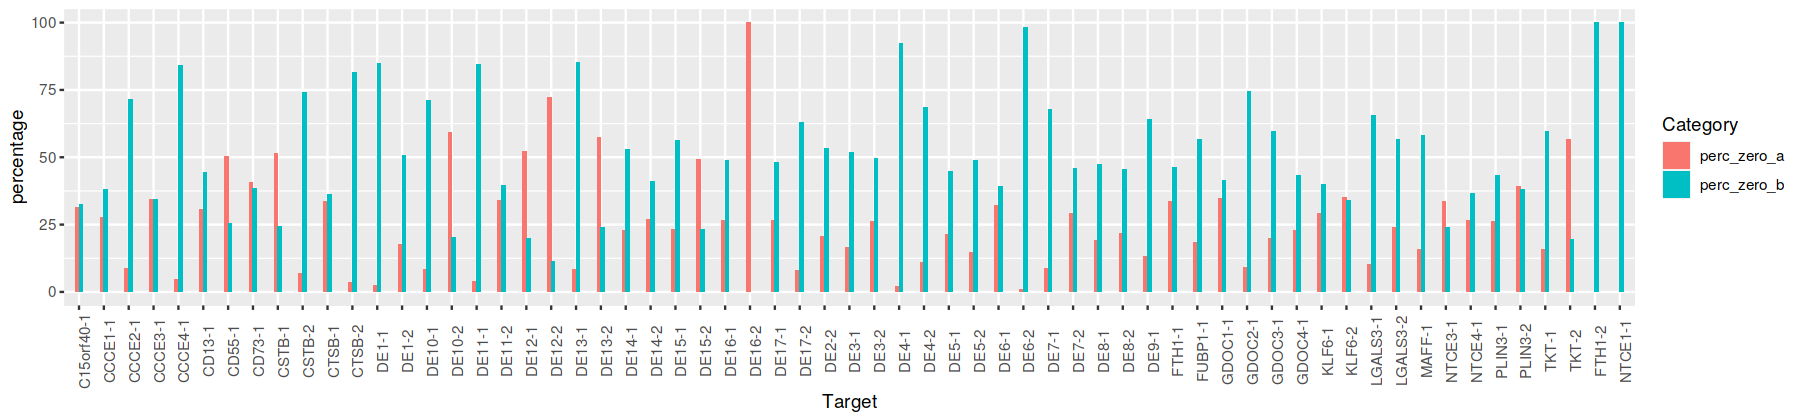

In [72]:
options(repr.plot.width=15, repr.plot.height=3.5)

ggplot(df_dummy, aes(fill=Category, y=percentage, x=Target)) +
    geom_bar(position='dodge', stat='identity', width=0.3) +
    theme(axis.text.x = element_text(angle = 90))


End debug

In [73]:
### Plot ditributions for 

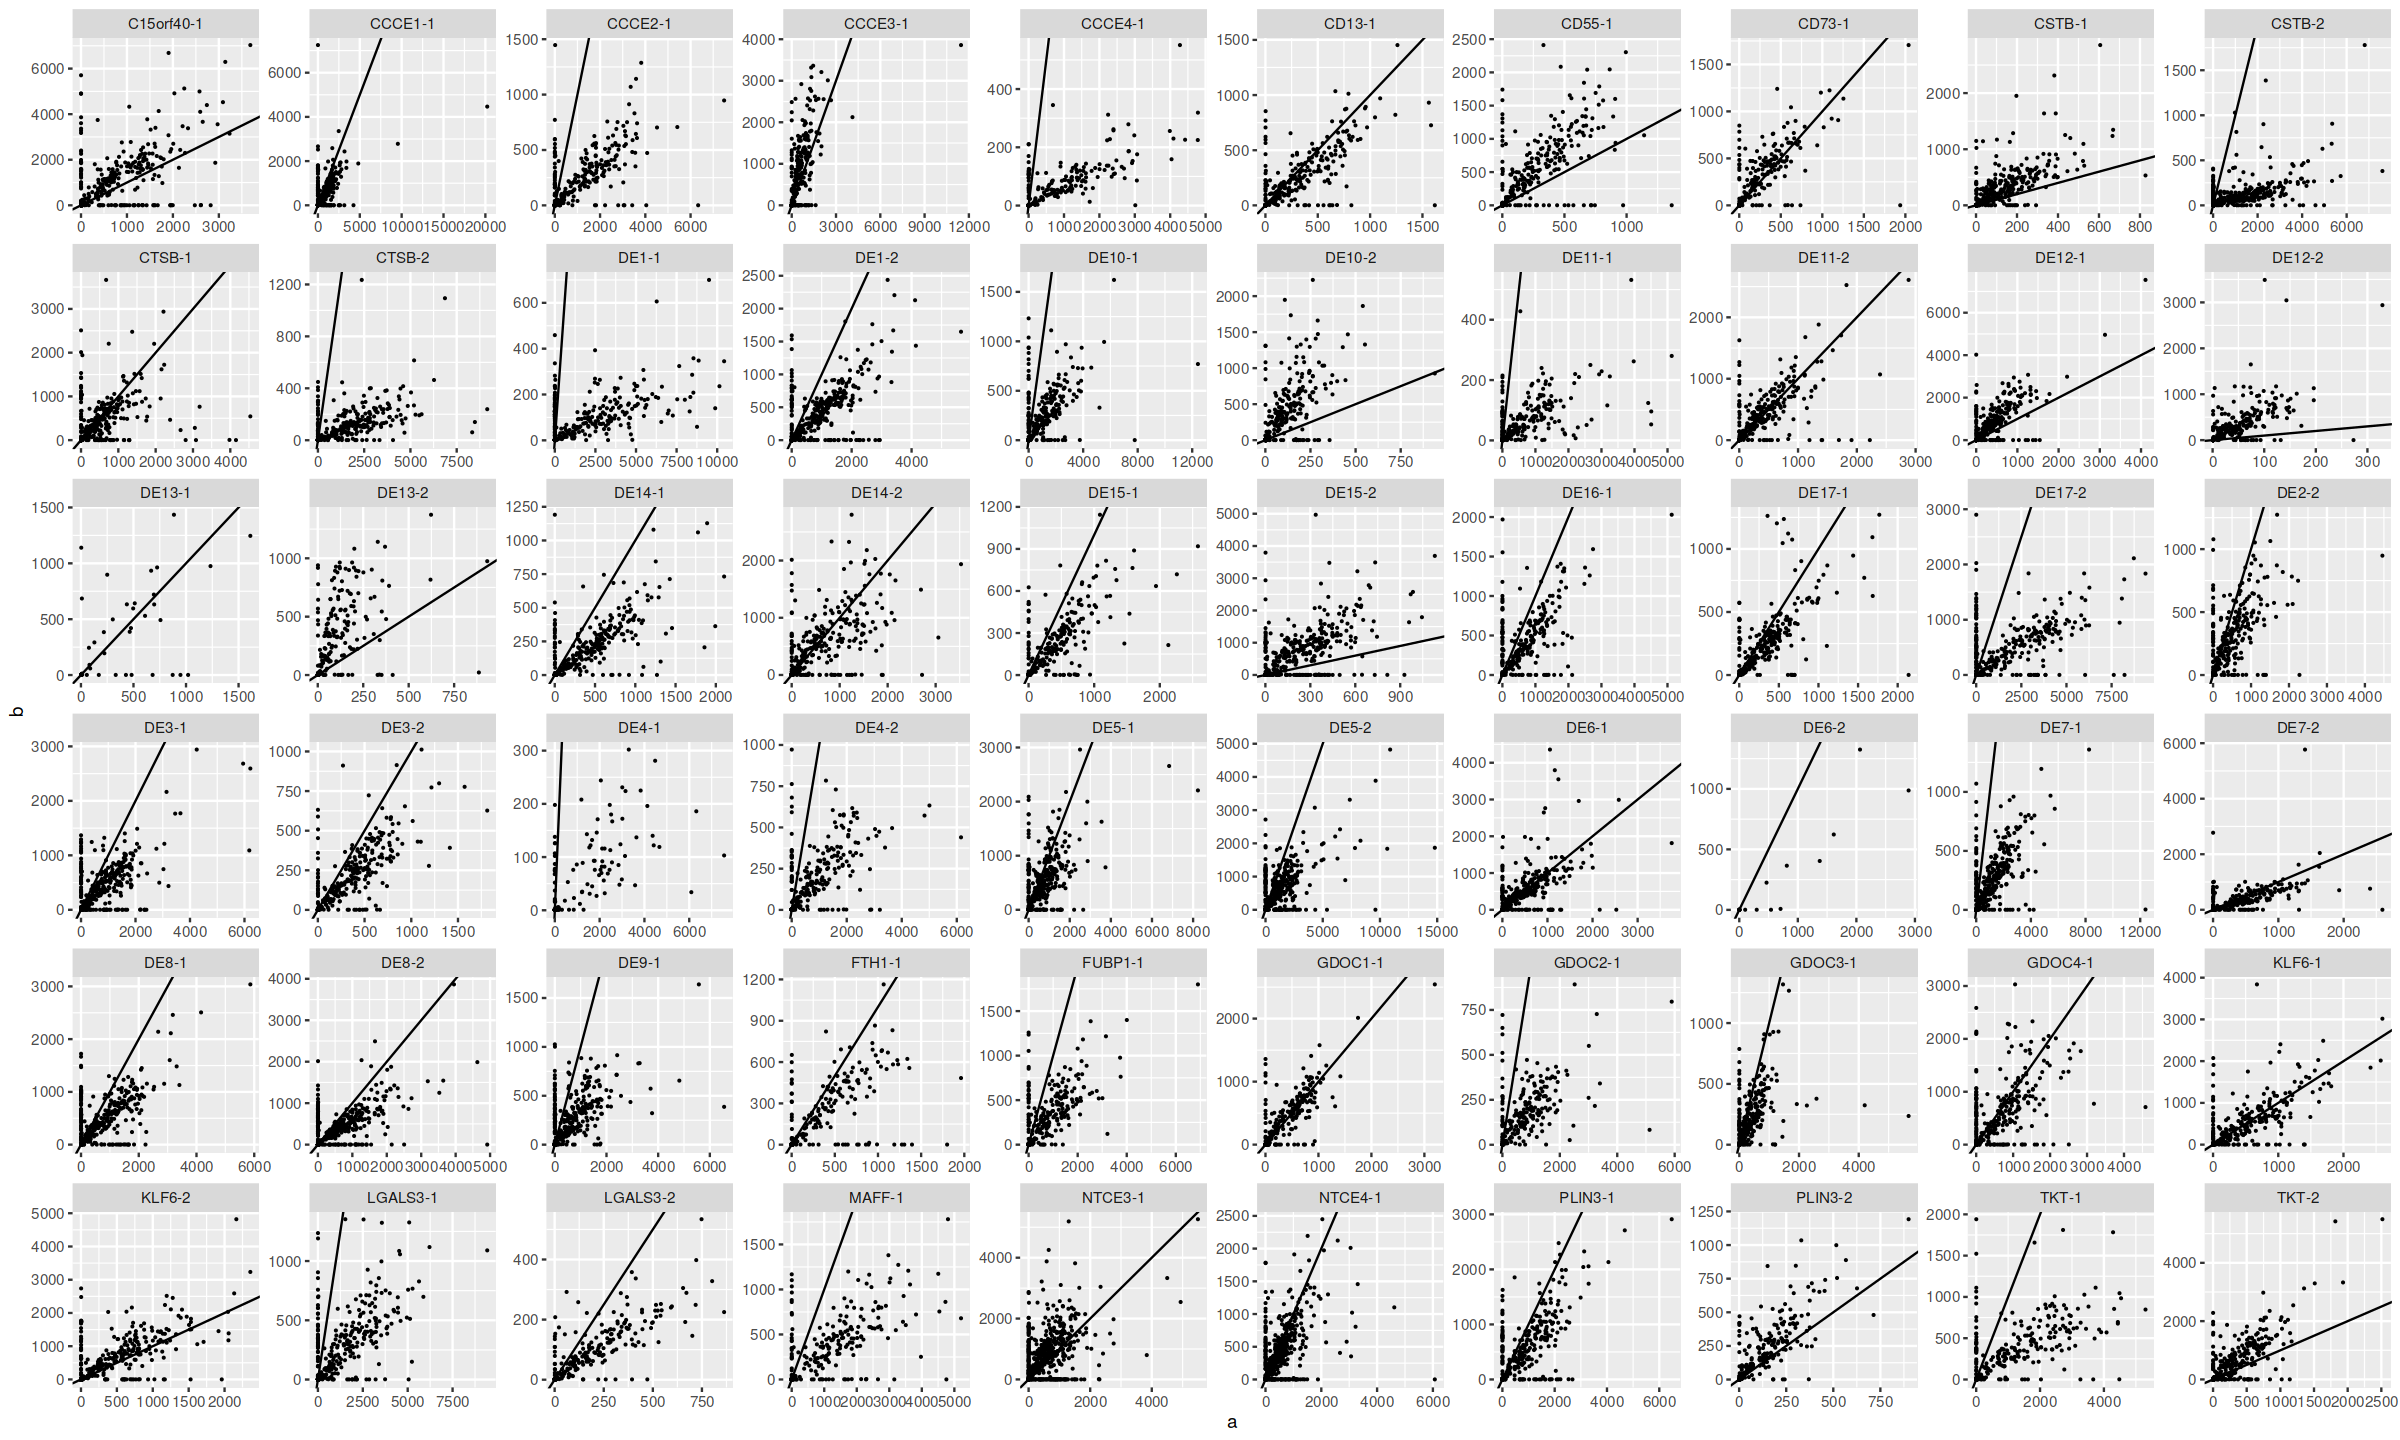

In [74]:
select_nonzero = (df_pair$a > 0) & (df_pair$b > 0)
df_pair = df_pair[select_nonzero,]

options(repr.plot.width=20, repr.plot.height=12)

p1 <- ggplot(df_pair, aes(x=a, y=b)) +
    geom_point(size=.1) +
    geom_abline(slope=1, intercept = 0) +
    facet_wrap(~ PS, scales="free", ncol = 10)

p1

### Visualize guide count distribution before demux

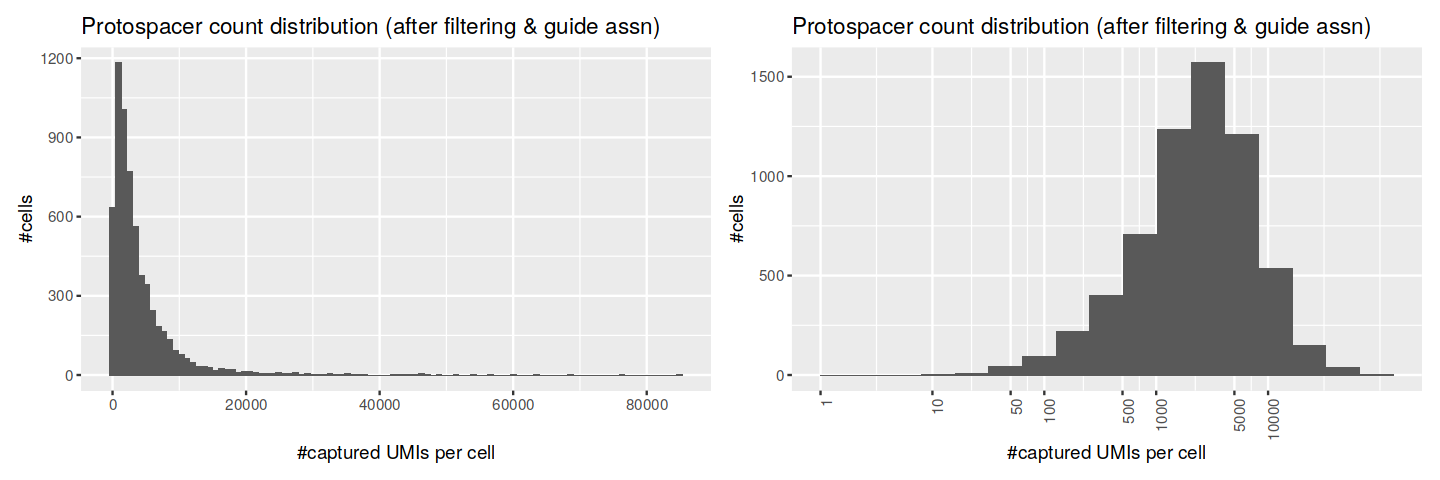

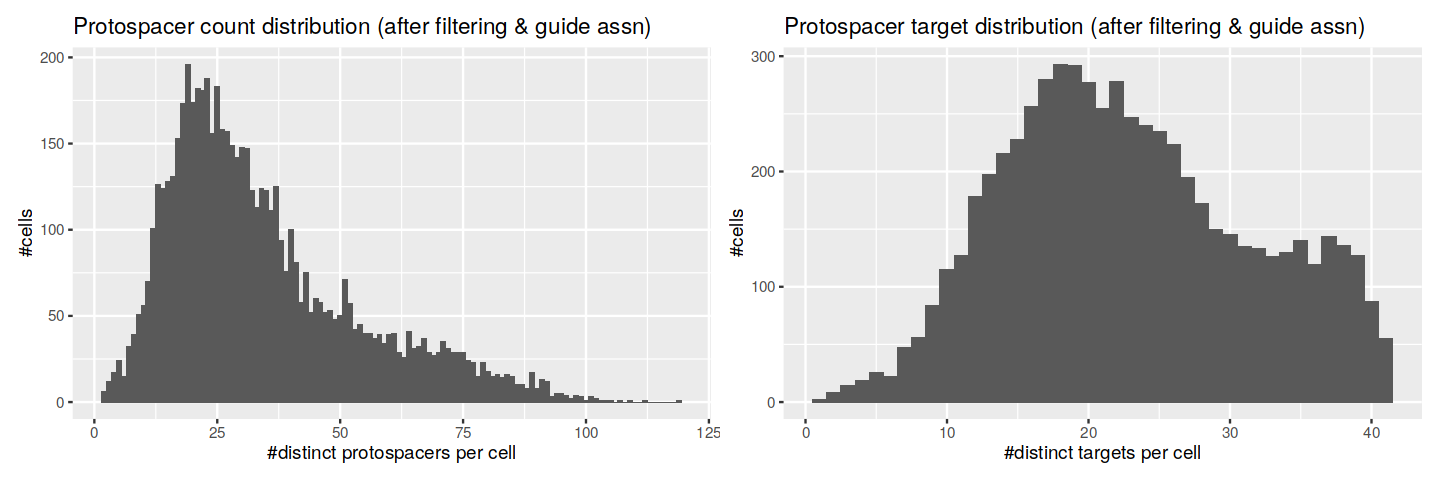

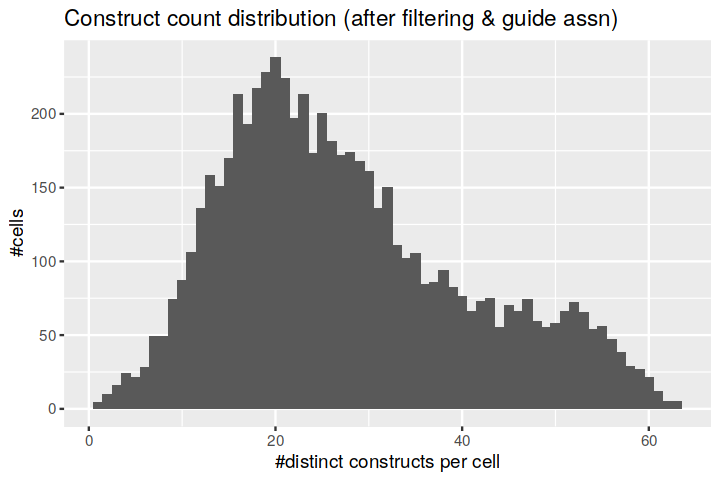

In [75]:
df_seurat <- seurat[[]]
bin_breaks <- c(1,2,2*2^(1:16))

p1 <- ggplot(df_seurat, aes(x = nCount_sgRNA)) +
    geom_histogram(bins=100) +
    labs(title = "Protospacer count distribution (after filtering & guide assn)", x = "#captured UMIs per cell") +
    labs(y = "#cells") 

p1b <- ggplot(df_seurat, aes(x = nCount_sgRNA)) +
    geom_histogram(breaks=bin_breaks) +
    scale_x_log10(breaks=c(1,10,50,100,500,1000,5000,10000)) +
    labs(title = "Protospacer count distribution (after filtering & guide assn)", x = "#captured UMIs per cell") +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(y = "#cells") 

p2 <- ggplot(df_seurat, aes(x = nFeature_sgRNA)) +
    geom_histogram(binwidth=1) +
    labs(title = "Protospacer count distribution (after filtering & guide assn)", x = "#distinct protospacers per cell") +
    labs(y = "#cells") 

p3 <- ggplot(df_guides_by_target, aes(x = total_targets)) +
    geom_histogram(binwidth=1) +
    labs(title = "Protospacer target distribution (after filtering & guide assn)", x = "#distinct targets per cell") +
    labs(y = "#cells") 


p4 <- ggplot(df_guides_by_vector, aes(x = total_vectors)) +
    geom_histogram(binwidth=1) +
    labs(title = "Construct count distribution (after filtering & guide assn)", x = "#distinct constructs per cell") +
    labs(y = "#cells") 

options(repr.plot.width=12, repr.plot.height=4)
p1 | p1b
p2 | p3
options(repr.plot.width=6, repr.plot.height=4)
p4

### Visualize guide count distribution before demux

In [76]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL
df_guide_counts$n_guides <- rowSums(df_guide_counts)

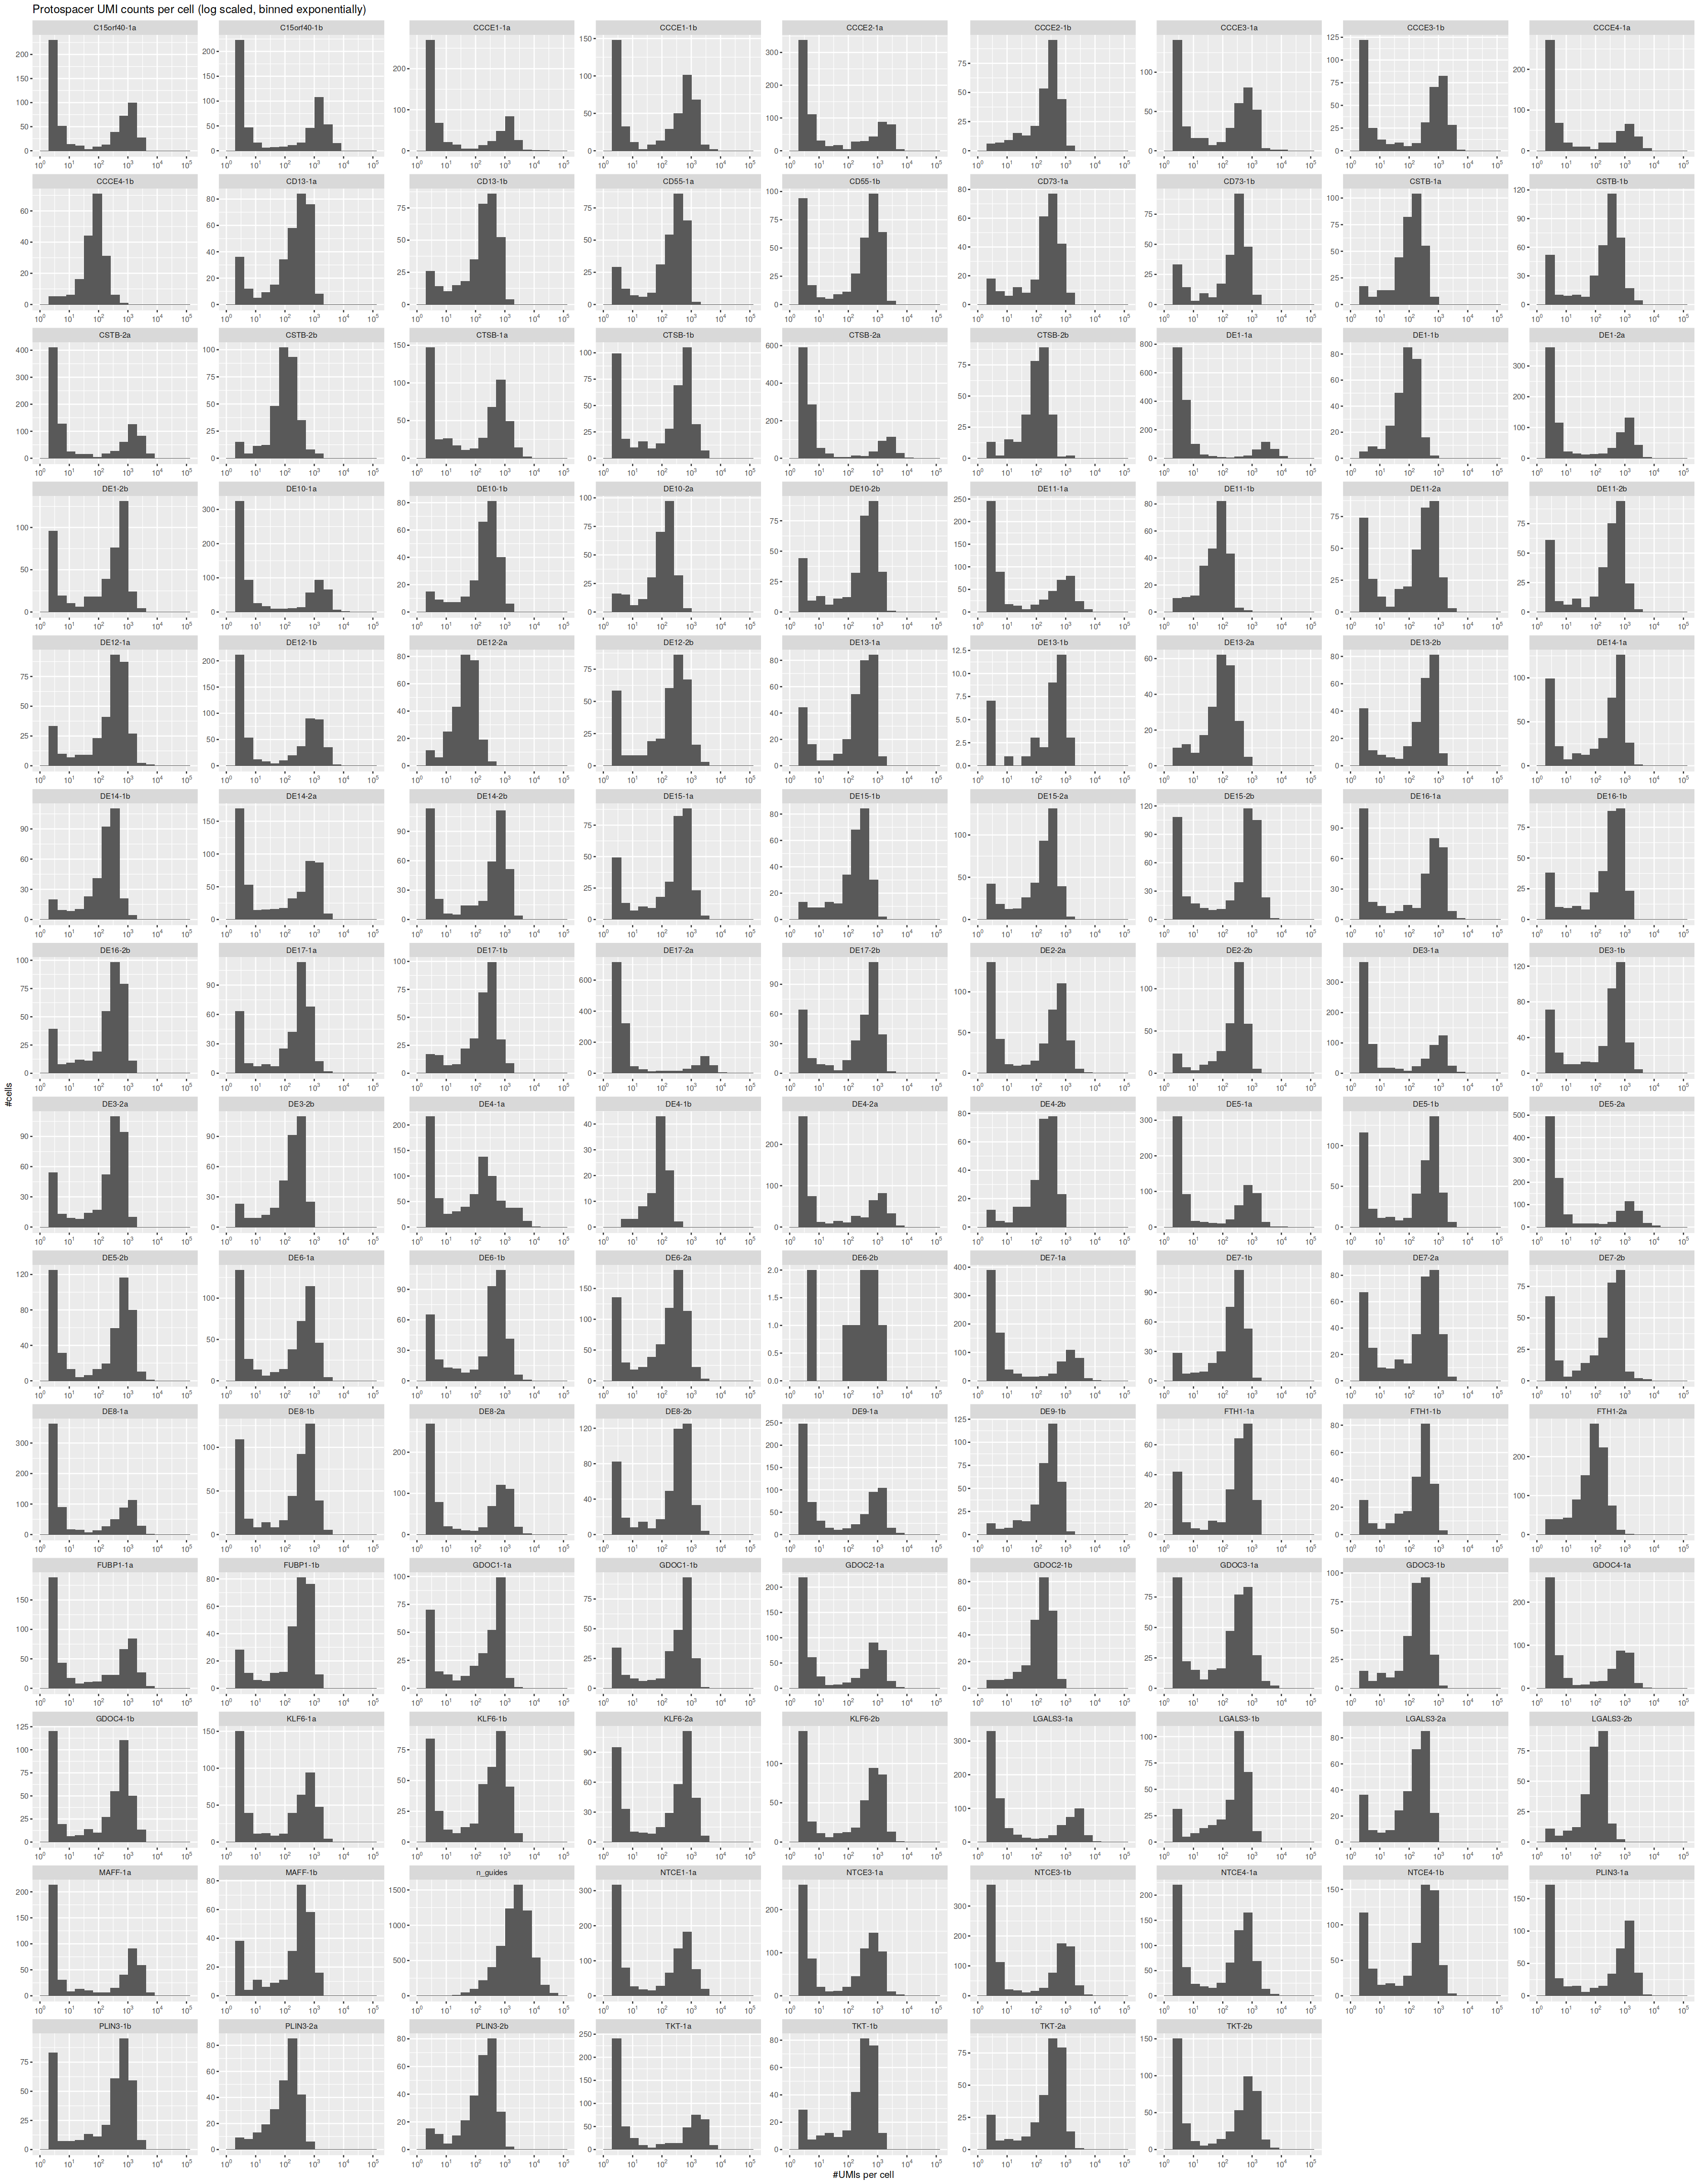

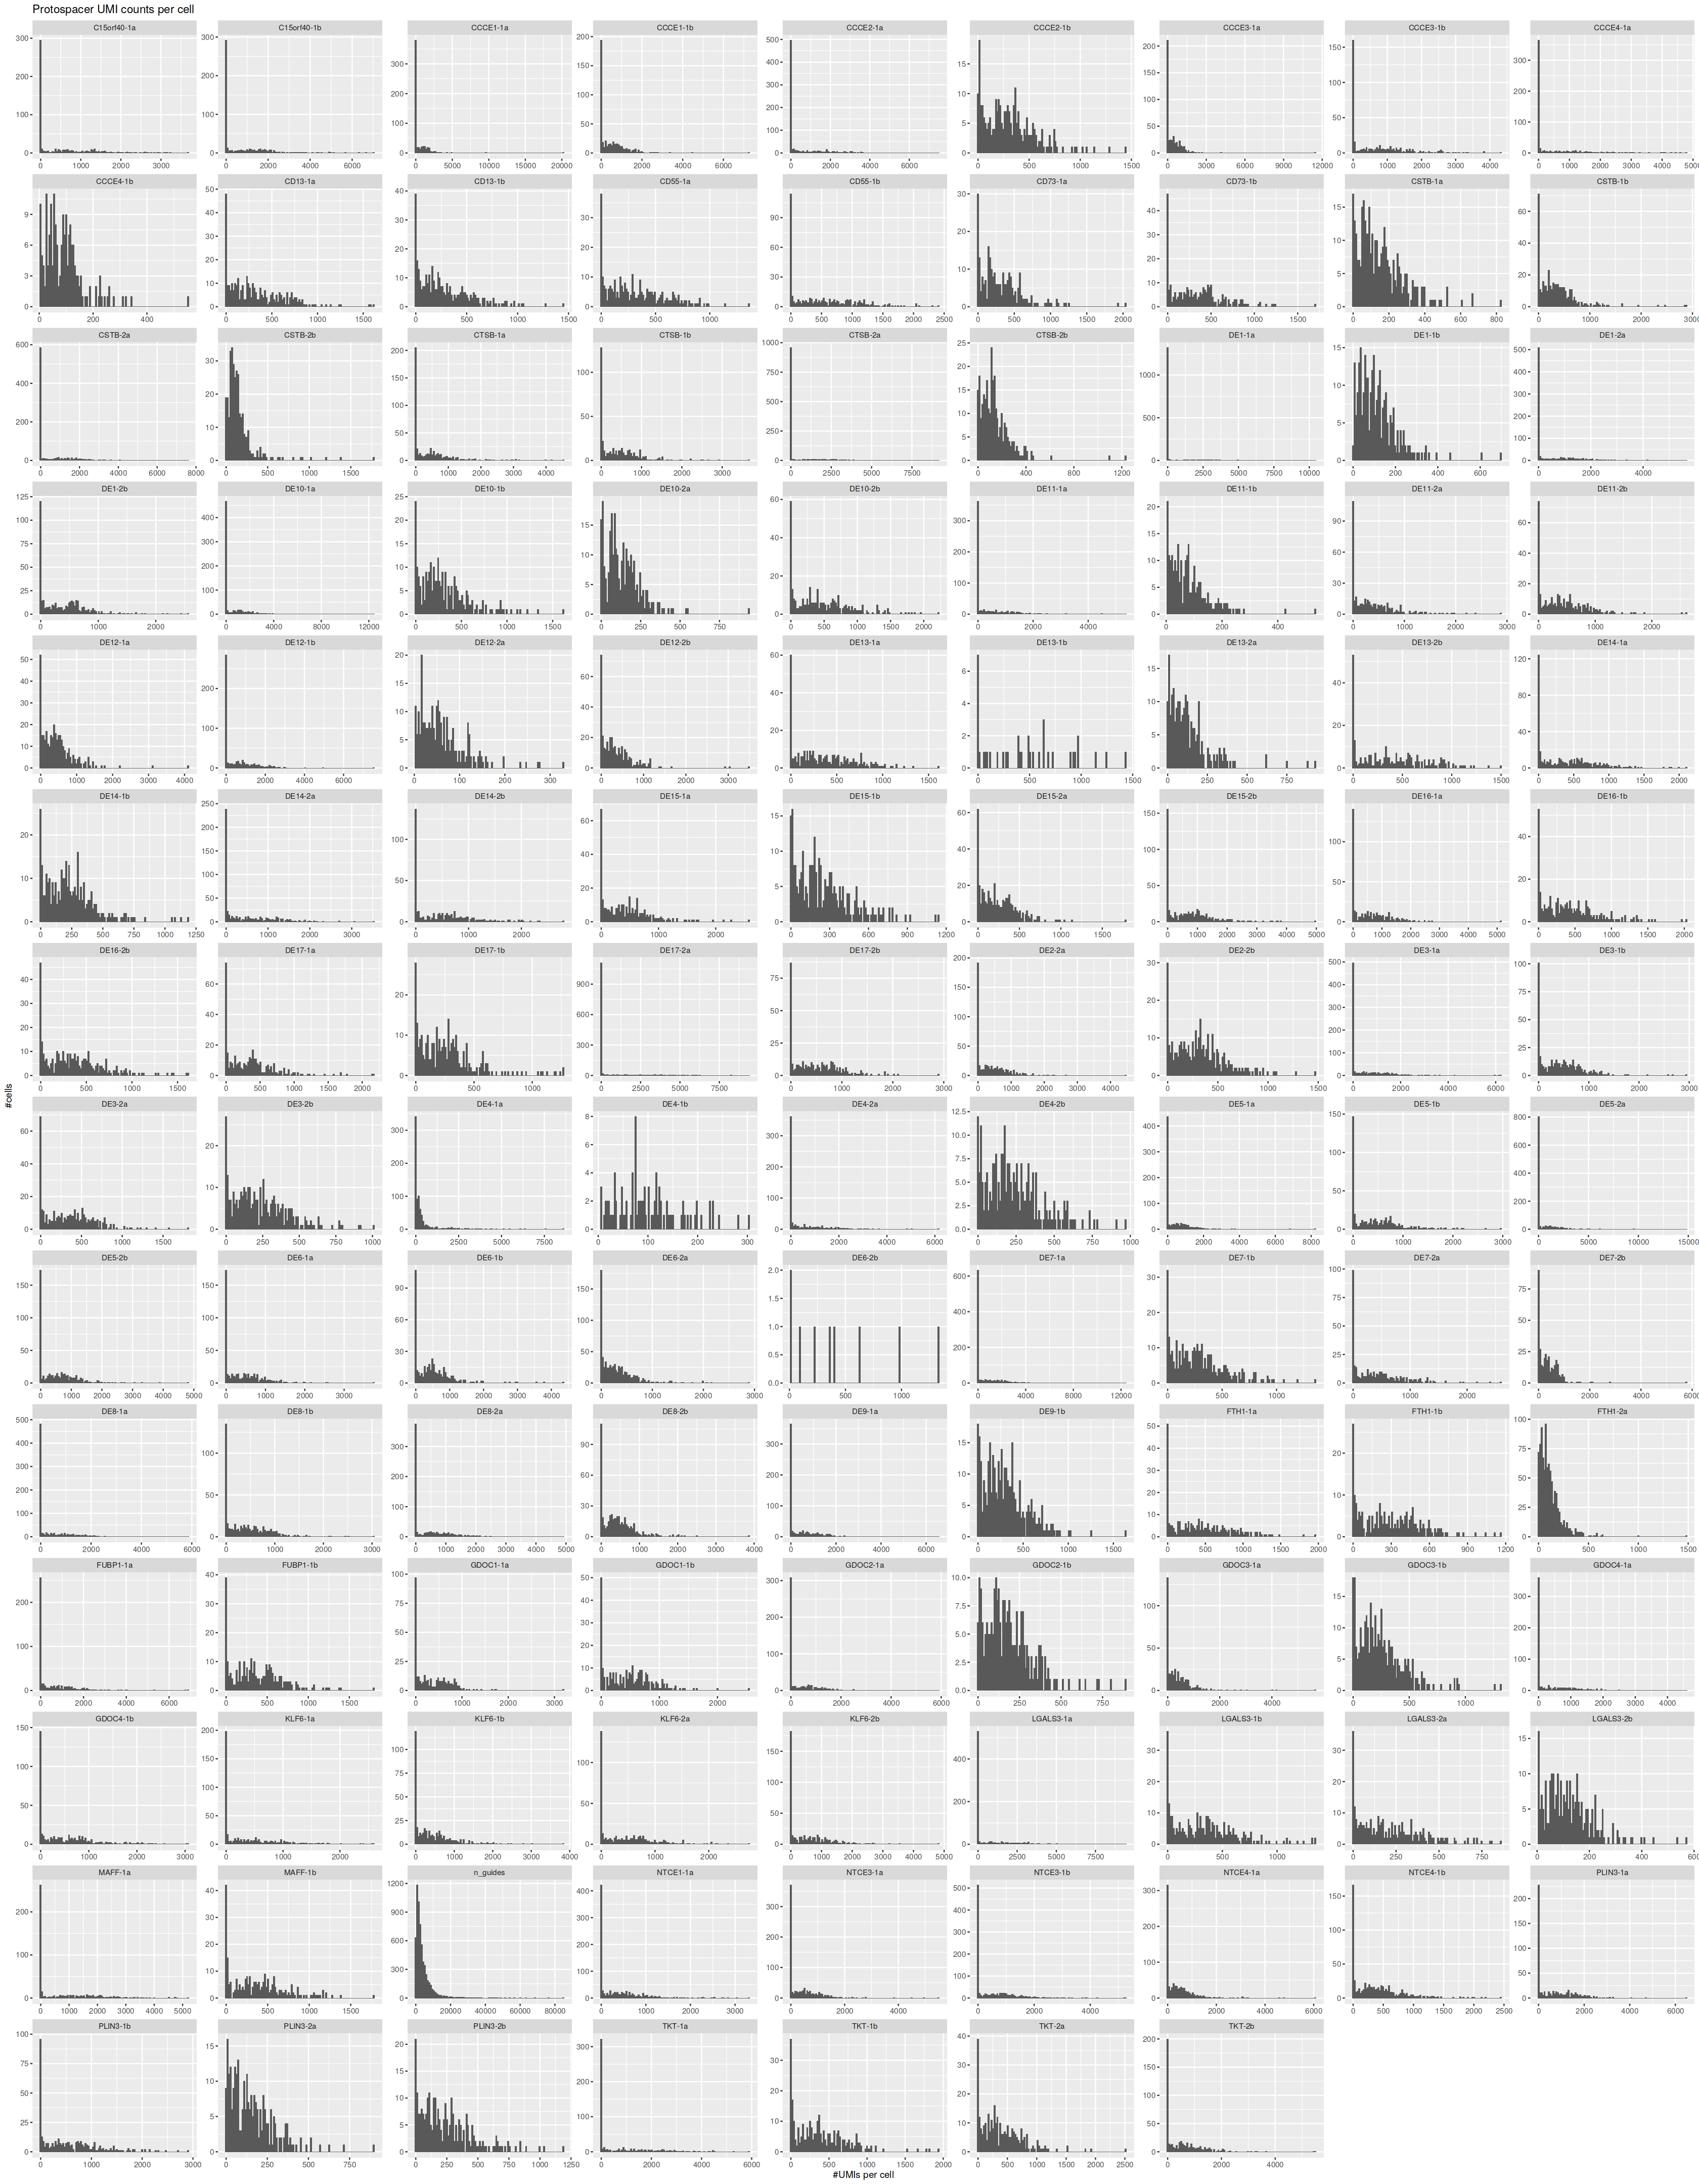

In [78]:
options(repr.plot.width=28, repr.plot.height=36)

data_long <- df_guide_counts %>%                    
  pivot_longer(colnames(df_guide_counts)) %>% 
  as.data.frame()

filter_zeros = data_long$value > 2
data_long <- data_long[filter_zeros,]
bin_breaks <- c(1,2,2*2^(1:16))

ggp1 <- ggplot(data_long, aes(x = value)) +    # Draw each column as histogram
  geom_histogram(breaks=bin_breaks) + 
  scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
  labs(title="Protospacer UMI counts per cell (log scaled, binned exponentially)", x="#UMIs per cell", y="#cells") +
  facet_wrap(~ name, scales = "free", ncol = 9)

ggp2 <- ggplot(data_long, aes(x = value)) +    # Draw each column as histogram
  geom_histogram(bins=100) + 
  labs(title="Protospacer UMI counts per cell", x="#UMIs per cell", y="#cells") +
  facet_wrap(~ name, scales = "free", ncol = 9)

ggp1
ggp2

# Plot Cellranger-demuxed counts (guide assignment)

## Plot all donors together first

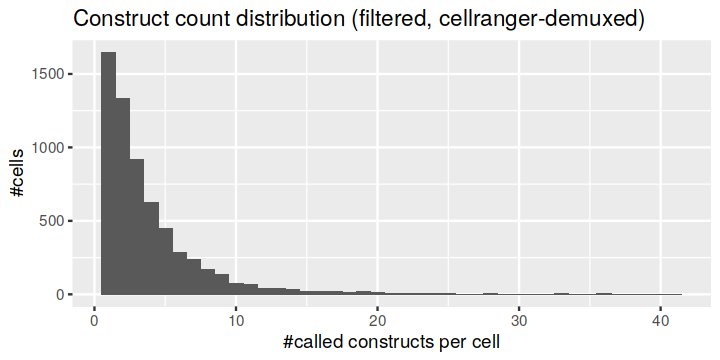

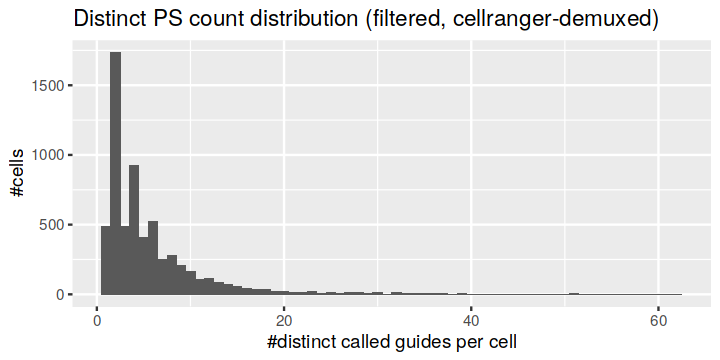

In [77]:
df_metadata = seurat@meta.data

p5 <- ggplot(df_metadata, aes(x = nCalled_Constructs)) +
    geom_histogram(binwidth=1) +
    labs(title = "Construct count distribution (filtered, cellranger-demuxed)", x = "#called constructs per cell") +
    labs(y = "#cells") 

p6 <- ggplot(df_metadata, aes(x = nPS_calls)) +
    geom_histogram(binwidth=1) +
    labs(title = "Distinct PS count distribution (filtered, cellranger-demuxed)", x = "#distinct called guides per cell") +
    labs(y = "#cells") 


options(repr.plot.width=6, repr.plot.height=3)
p5
p6

In [79]:
# library("vcd")
# filter_outliers = df_metadata$nCalled_Constructs < 20 
# n_constructs = df_metadata[filter_outliers, ]$nCalled_Constructs
# gf1 = goodfit(n_constructs, "poisson")
# rootogram(gf1, xlab = "", rect_gp = gpar(fill="chartreuse4"))

In [80]:
mean_constructs   <- round(mean(df_metadata$nCalled_Constructs),2)
median_constructs <- round(median(df_metadata$nCalled_Constructs),2)
n_guide_assigned_cells   <- nrow(df_metadata)
n_filtered_cells <- length(Cells(seurat))

n_cells_from_cellranger = ncol(rna_counts)
n_protospacers = nrow(sgrna_counts)
n_genes = nrow(rna_counts)

In [81]:
stats[["Mean_distinct_plasmids_per_cell_in_singlets_MOI_cellranger_caller):"]] <- paste(mean_constructs)
stats[["Median_distinct_plasmids_cell_in_singlets_MOI_cellranger caller):"]]   <- paste(median_constructs)

In [82]:
n_cells_from_cellranger
nrow(df_metadata)

[1] 9169

[1] 6209

# Perturbation+/- counts

## Create a cell/target df

In [83]:
all_construct_calls = paste0(as.vector(seurat$construct_call), collapse="|")
all_construct_calls = strsplit(all_construct_calls, split = "\\|")
df_construct_counts = as.data.frame(table(head(all_construct_calls)))
colnames(df_construct_counts) <- c("Construct", "Count")

In [84]:
head(df_construct_counts, 2)

Construct  Count
1 C15orf40_1 338  
2 CCCE1_1    340

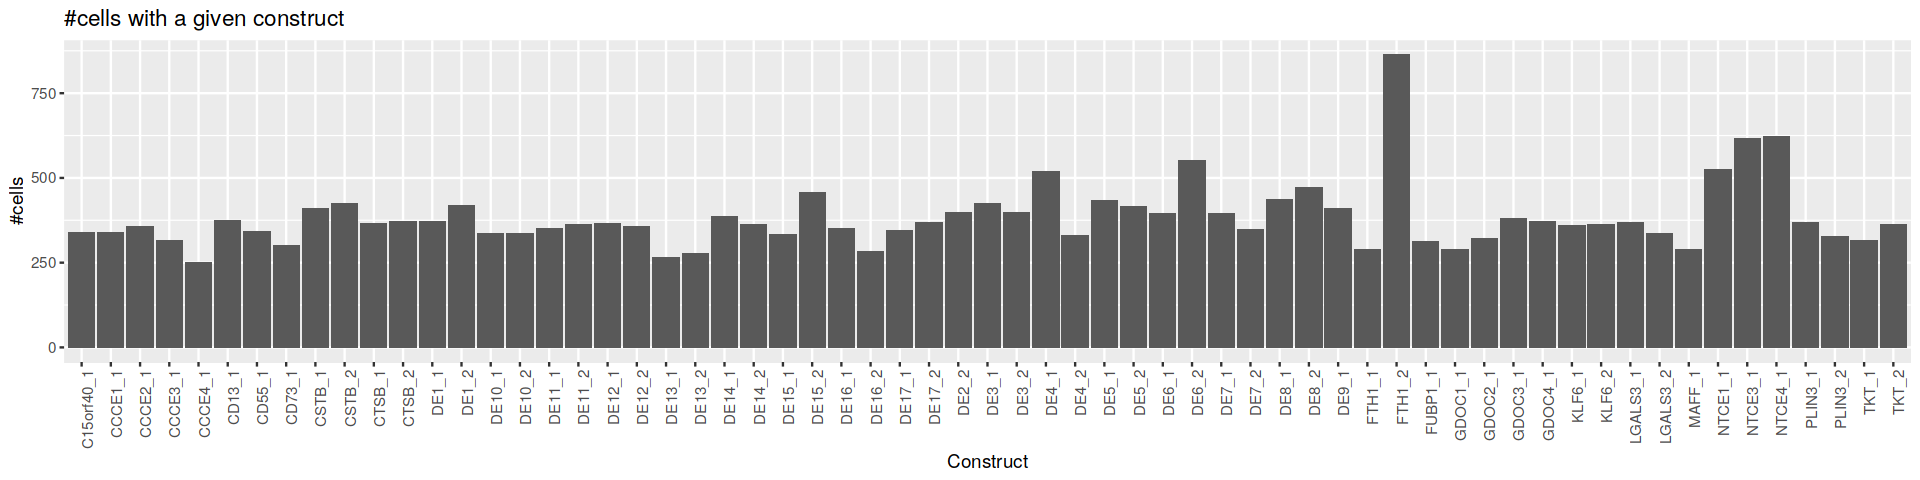

In [85]:
p6 <- ggplot(df_construct_counts, aes(x = Construct,y = Count))+
    geom_bar(stat='identity') +
    labs(title = "#cells with a given construct", x = "Construct") +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(y = "#cells") 

options(repr.plot.width=16, repr.plot.height=4)
p6

In [87]:
prefilter_vector_sums = colSums(df_guides_by_vector != 0)

In [88]:
prefilter_vector_sums[['FTH1-1']]
prefilter_vector_sums[['FTH1-2']]

[1] 1928

[1] 1808

# Perturbation+/- counts

## Create a cell/target df

In [89]:
targets = colnames(df_guides_by_target)
rownames(df_guides_by_target) <- rownames(as.data.frame(t(seurat[['sgRNA']]@counts)))

In [90]:
df_targets <- subset(df_guides_by_target, select=-total_targets)

In [91]:
df_targets[] <- FALSE

In [92]:
for(barcode in rownames(df_guides_by_target)){
    target_list <- as.character(seurat@meta.data[barcode, 'target_call'])
    targets = strsplit(target_list, "\\|")[[1]]
    for(target in targets) {
        df_targets[barcode, target] <- TRUE
    }
}

Double-check the target assignments

In [93]:
for(bc in rownames(df_guides_by_target)){
    eq = sum(df_targets[bc,]) == length(strsplit(as.character(seurat@meta.data[bc,'target_call']), "\\|")[[1]])
    if(!eq) { 
        print(bc)
        break
    }
}

In [94]:
colnames(df_targets)

[1] "CD13"     "CD55"     "CD73"     "FUBP1"    "C15orf40" "MAFF"    
 [7] "FTH1"     "PLIN3"    "TKT"      "LGALS3"   "CSTB"     "CTSB"    
[13] "KLF6"     "DE1"      "DE2"      "DE3"      "DE4"      "DE5"     
[19] "DE6"      "DE7"      "DE8"      "DE9"      "DE10"     "DE11"    
[25] "DE12"     "DE13"     "DE14"     "DE15"     "DE16"     "DE17"    
[31] "NTCE1"    "NTCE2"    "NTCE3"    "NTCE4"    "GDOC1"    "GDOC2"   
[37] "GDOC3"    "GDOC4"    "CCCE1"    "CCCE2"    "CCCE3"    "CCCE4"

## Get counts for each target+/- set

In [95]:
n_cells = nrow(df_targets)
n_targets = ncol(df_targets)
df_pos_neg = data.frame(n_positives=rep(0,n_targets), n_negatives=rep(0, n_targets))
rownames(df_pos_neg) = colnames(df_targets)

for(target in colnames(df_targets)) {   
    n_pos <- sum(df_targets[, target] == TRUE)
    df_pos_neg[target, 'n_positives']  <- n_pos
    df_pos_neg[target, 'n_negatives']  <- n_cells - n_pos
    #cat(target, pos_count, neg_count, "\n")
}

select_nonzeros <- df_pos_neg[,'n_positives'] > 0
df_pos_neg <- df_pos_neg[select_nonzeros,]

In [96]:
head(df_pos_neg)

n_positives n_negatives
CD13     375         5834       
CD55     343         5866       
CD73     301         5908       
FUBP1    312         5897       
C15orf40 338         5871       
MAFF     288         5921

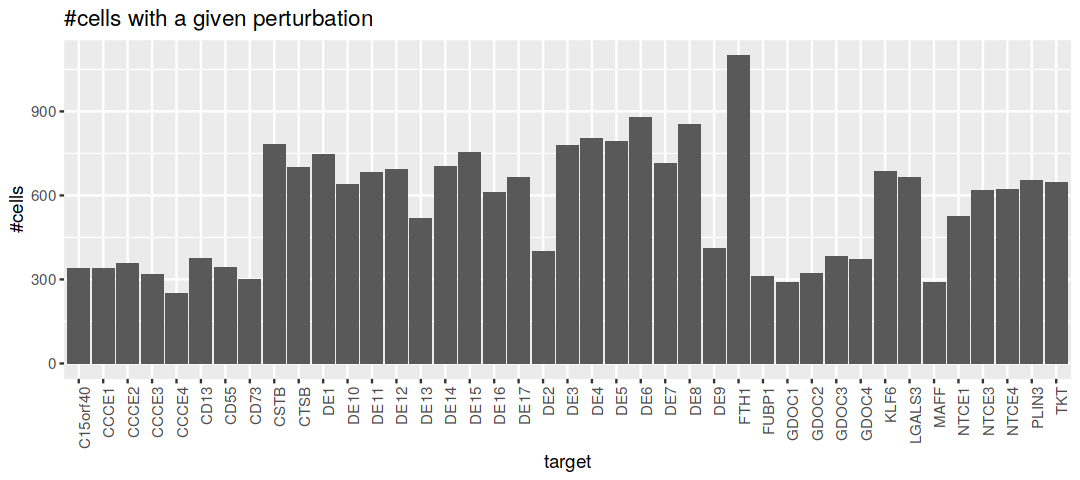

In [97]:
# Create a histogram from df_pos_neg column n_positives

p6 <- ggplot(df_pos_neg, aes(x = rownames(df_pos_neg),y = n_positives)) +
    geom_bar(stat='identity') +
    labs(title = "#cells with a given perturbation", x = "target") +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(y = "#cells") 

options(repr.plot.width=9, repr.plot.height=4)
p6


# Load Souporcell outputs

In [98]:
df_soup = read.csv(souporcell_clusters_path, sep="\t")
head(df_soup,2)

barcode            status  assignment log_prob_singleton log_prob_doublet
1 AAACCCAAGAGCAGCT-1 singlet 3           -695               -837           
2 AAACCCAAGCCGGAAT-1 doublet 1/2        -6694              -4669           
  cluster0 cluster1 cluster2 cluster3
1 -2104    -2279    -2433      -695  
2 -8876    -6694    -6876    -11522

## Assign singlet/doubletstatus to Seurat cells

In [102]:
df_meta <- seurat@meta.data
df_meta$barcode <- rownames(df_meta)
df_assignment   <- subset(df_soup, select=c('barcode', 'status', 'assignment'))

#df_dummy <- merge(df_meta, df_assignment, on='barcode')
df_dummy <- inner_join(df_meta, df_assignment, by='barcode')
nrow(df_meta)
nrow(df_dummy)
#head(df_meta)
#head(df_dummy)


[1] 6209

[1] 6209

In [103]:
seurat$status = df_dummy$status
seurat$donor  = df_dummy$assignment

Check if join worked ok

In [115]:
rownames(df_soup) = df_soup$barcode
any(df_soup[rownames(seurat@meta.data), 'status'] != seurat@meta.data$status)

[1] 0

Get souporcell assginment counts

In [121]:
table(df_soup$status)


   doublet    singlet unassigned 
       918       8171         80 

### Eliminate doublets

How many doublets among the filtered cells? 

In [104]:
select_doublets = (df_soup$status == 'doublet')
doublet_cells   = df_soup[select_doublets,]$barcode
seurat_cells    = Cells(seurat)

select_singlets = (df_soup$status == 'singlet')
singlet_cells   = df_soup[select_singlets,]$barcode
seurat = subset(seurat, cells=singlet_cells)

stats[["Doublets in filtered cells"]] = length(intersect(doublet_cells, seurat_cells))
stats[["Total doublets before filtering"]] = length(doublet_cells)
stats[["Singlets after filtering"]] = length(Cells(seurat))
stats[["Singlets% after filtering"]] = round(length(Cells(seurat))/length(seurat_cells),1)

## Split donors, then plot

In [105]:
head(df_soup,2)

barcode            status  assignment log_prob_singleton log_prob_doublet
1 AAACCCAAGAGCAGCT-1 singlet 3           -695               -837           
2 AAACCCAAGCCGGAAT-1 doublet 1/2        -6694              -4669           
  cluster0 cluster1 cluster2 cluster3
1 -2104    -2279    -2433      -695  
2 -8876    -6694    -6876    -11522

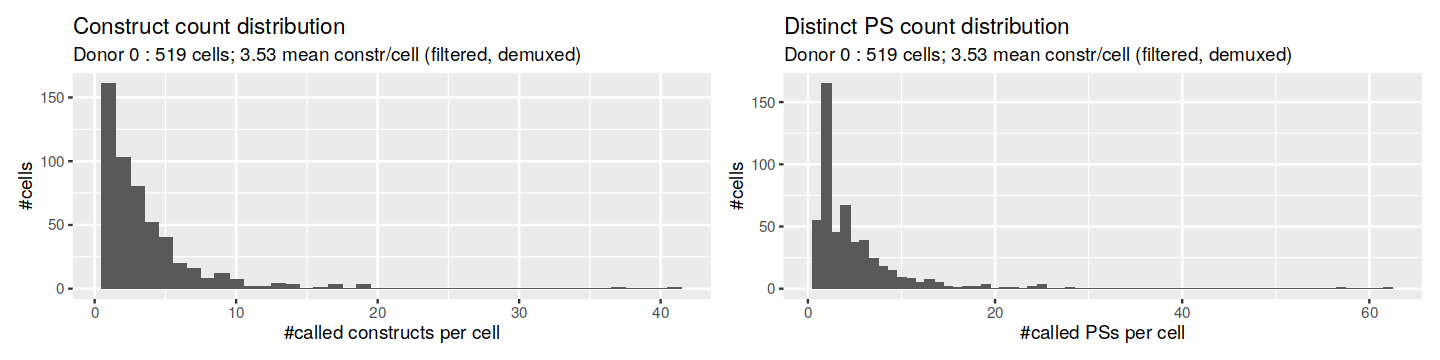

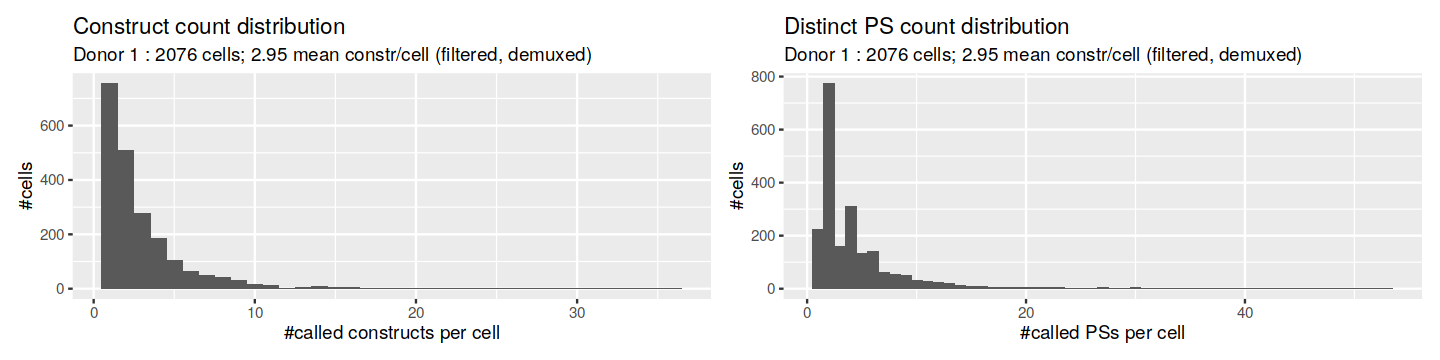

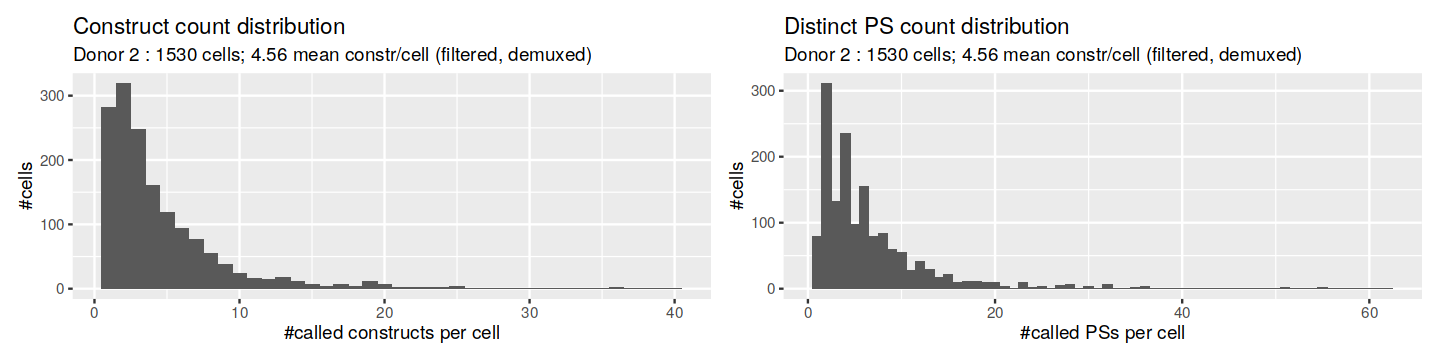

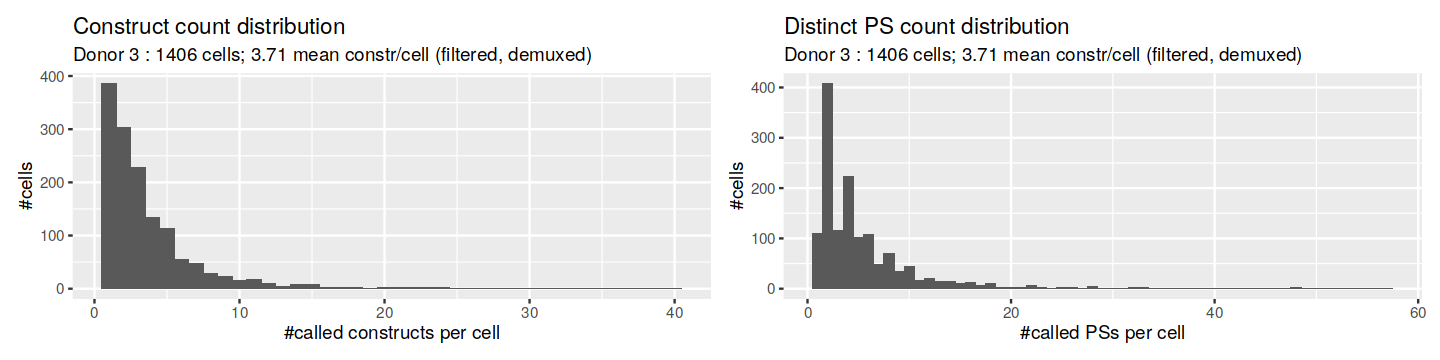

In [106]:
donors = c(0, 1, 2, 3)

for(donor_id in donors){
    select_donor = (df_soup$assignment == donor_id) & (df_soup$status == 'singlet')
    donor_cells = df_soup[select_donor,]$barcode
    seurat_donor = subset(seurat, cells = donor_cells)
    n_donor_cells = length(Cells(seurat_donor))
    df_metadata = seurat_donor@meta.data
    mean_constructs   <- round(mean(df_metadata$nCalled_Constructs),2)

    title = "Construct count distribution"
    subtitle = paste(
                    "Donor", donor_id, 
                    ":", n_donor_cells, "cells;", 
                    mean_constructs, "mean constr/cell",
                    "(filtered, demuxed)"
                )
    
    stats[[paste0("Donor_", donor_id, "_mean_constr_cell")]] = mean_constructs
    stats[[paste0("Donor_", donor_id, "_cells" )]] = n_donor_cells

    p5 <- ggplot(df_metadata, aes(x = nCalled_Constructs)) +
        geom_histogram(binwidth=1) +
        labs(title = title, subtitle = subtitle, x = "#called constructs per cell") +
        labs(y = "#cells") 

    title = "Distinct PS count distribution "
    p6 <- ggplot(df_metadata, aes(x = nPS_calls)) +
        geom_histogram(binwidth=1) +
        labs(title = title, subtitle = subtitle, x = "#called PSs per cell") + 
        labs(y = "#cells") 

    options(repr.plot.width=12, repr.plot.height=3)
    print(p5 | p6)
    #options(repr.plot.width=6, repr.plot.height=3)
    #print(p6)
}

### Add stats into the misc slot

In [107]:
Misc(seurat, slot = 'stats') <- stats

In [119]:
unique(seurat$status)

[1] "singlet"

# Save to Seurat H5

In [105]:
if(save_seurat_h5 == "YES") {
    print("Saving h5...")
    SaveH5Seurat(seurat, filename=save_h5_file, overwrite=TRUE, verbose=FALSE)
}

In [ ]:
save_h5_file

[1] "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/Lib_1/seurat_objects/Screen1_66guides_Lib_1.h5seurat"

# Stats

In [116]:
for(stat in names(stats)){
    cat(blue(stat), ":", stats[[stat]], "\n")
}

Screen : Screen1_66guides 
Library : Lib_1 
Cells_recovered : 9169 
Genes_recovered : 31847 
Protospacers_in_assay : 132 
Max_mito_perc_threshold : 17 
Min_mito_perc_threshold : 3 
Max_n_RNA_threshold : 98264 
Min_n_RNA_threshold : -22058 
Max_n_genes_threshold : 12173 
Min_n_genes_threshold : 1837 
Cells_after_QC_filtering : 8015 
Cells_with_sgRNA_count_less_than_100 : 1786 
Cells_with_a_guide_assigned_by_Cellranger_caller : 6209 
Mean_distinct_plasmids_per_cell_in_singlets_MOI_cellranger_caller): : 3.89 
Median_distinct_plasmids_cell_in_singlets_MOI_cellranger caller): : 3 
Doublets in filtered cells : 677 
Total doublets before filtering : 918 
Singlets after filtering : 5531 
Singlets% after filtering : 0.9 
Donor_0_mean_constr_cell : 3.5 
Donor_0_cells : 519 
Donor_1_mean_constr_cell : 3 
Donor_1_cells : 2076 
Donor_2_mean_constr_cell : 4.6 
Donor_2_cells : 1530 
Donor_3_mean_constr_cell : 3.7 
Donor_3_cells : 1406 


In [106]:
stats_fname = paste0(stats_out_path, library_name, "_stats.tsv")
dir.create(stats_out_path, showWarnings = FALSE)
write.table(stats, file=stats_fname, quote=FALSE, sep='\t', col.names = NA)

In [117]:
unique(subset(seurat, cells=singlet_cells)$status)
unique(seurat$status)

[1] "singlet"

[1] "singlet"

#  Clustering QC

## Is clustering driven by UMI counts?

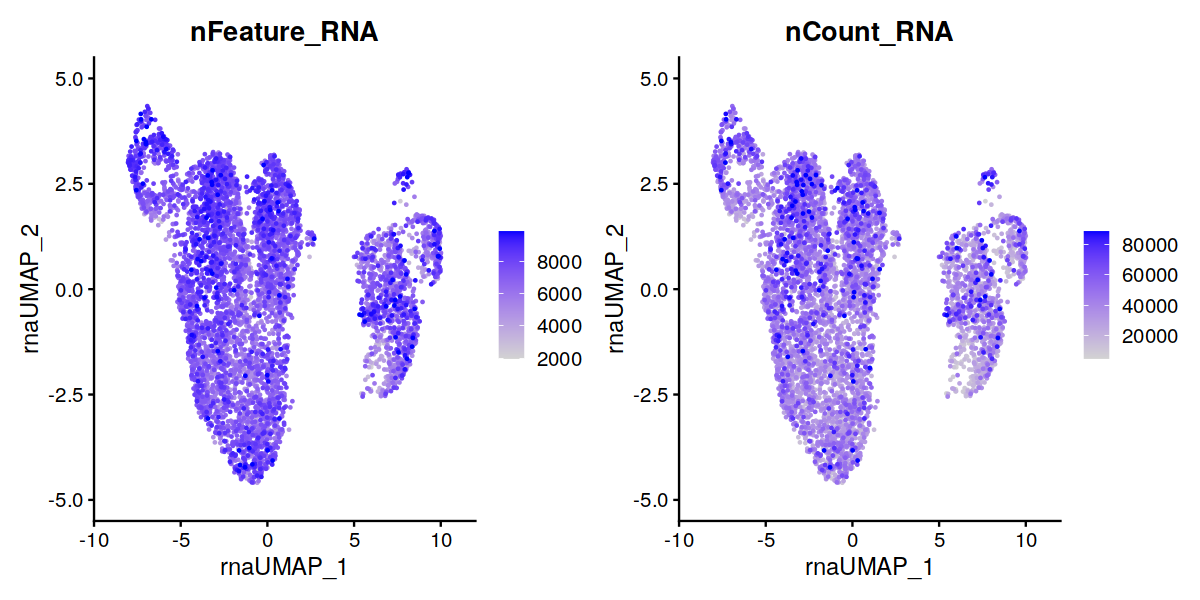

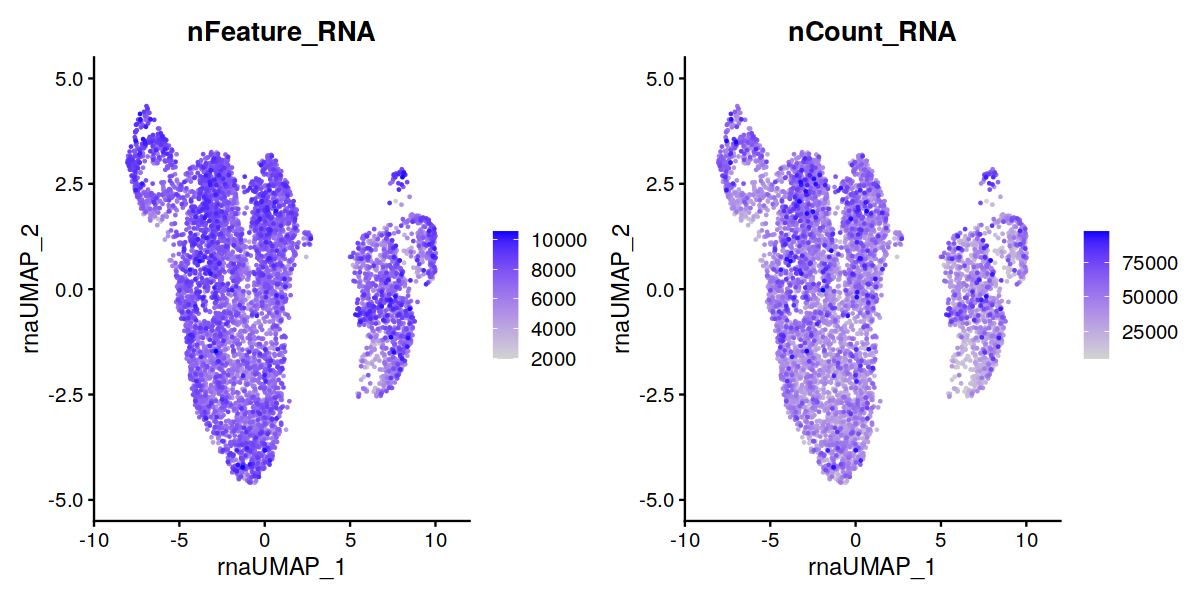

In [108]:
options(repr.plot.width=10, repr.plot.height=5)
FeaturePlot(
    seurat, 
    reduction= "umap.rna", 
    features = c("nFeature_RNA", "nCount_RNA"), 
    min.cutoff = NA, 
    max.cutoff = "q99", 
    ncol = 2, 
    order=T
)
FeaturePlot(
    seurat, 
    reduction= "umap.rna", 
    features = c("nFeature_RNA", "nCount_RNA"), 
    min.cutoff = NA, 
    max.cutoff = NA, 
    ncol = 2, 
    order=T
)

### Check if mito reads are driving the clustering

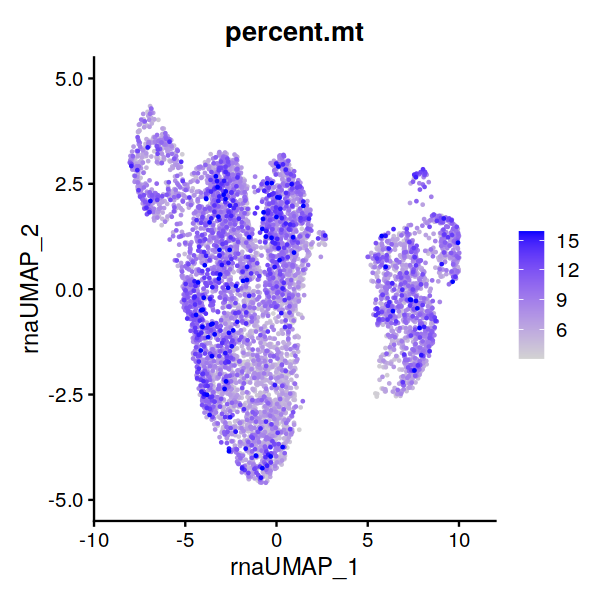

In [109]:
options(repr.plot.width=5, repr.plot.height=5)
FeaturePlot(seurat, reduction= "umap.rna", features = c("percent.mt"), min.cutoff = NA, max.cutoff = "q99", order=T)

# Stop

In [110]:
quit(save="no")

# -------

# Check the effect of the cell cycle

In [111]:
seurat <- CellCycleScoring(
    seurat, 
    s.features = s.genes, 
    g2m.features = g2m.genes, 
    set.ident = TRUE,
    assay = 'SCT'
)

Warning message:
"The following features are not present in the object: MLF1IP, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms"


Regress out the cell cylce effects

In [112]:
# DefaultAssay(seurat) <- "RNA"
# seurat <- SCTransform(
#     seurat, 
#     vst.flavor = "v2", 
#     verbose = FALSE, 
#     vars.to.regress = c('S.Score', 'G2M.Score')
# )  %>% 
#     RunPCA(features = c(s.genes, g2m.genes)) %>% 
#     RunUMAP(dims = 1:40, reduction.name = 'umap.rna', reduction.key = 'rnaUMAP_', verbose=FALSE)

Alternatively use this

In [113]:
#seurat <- RunPCA(seurat, features = c(s.genes, g2m.genes))

Picking joint bandwidth of 0.129

Picking joint bandwidth of 0.167

Picking joint bandwidth of 0.0817

Picking joint bandwidth of 0.115



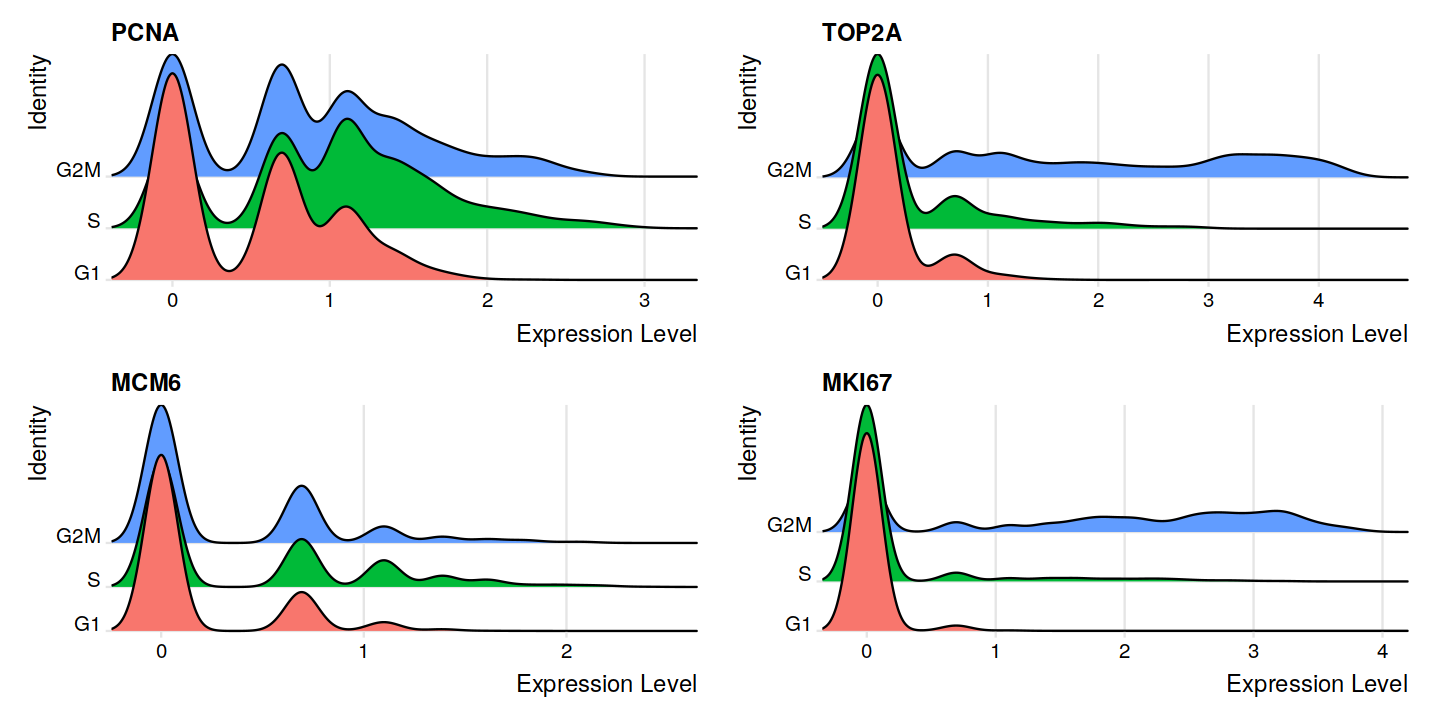

In [114]:
# Visualize the distribution of cell cycle markers across
options(repr.plot.width=12, repr.plot.height=6)
DefaultAssay(seurat) <- "SCT"
RidgePlot(seurat, features = c("PCNA", "TOP2A", "MCM6", "MKI67"), ncol = 2)

In [115]:
length(s.genes)
length(g2m.genes)

[1] 43

[1] 54

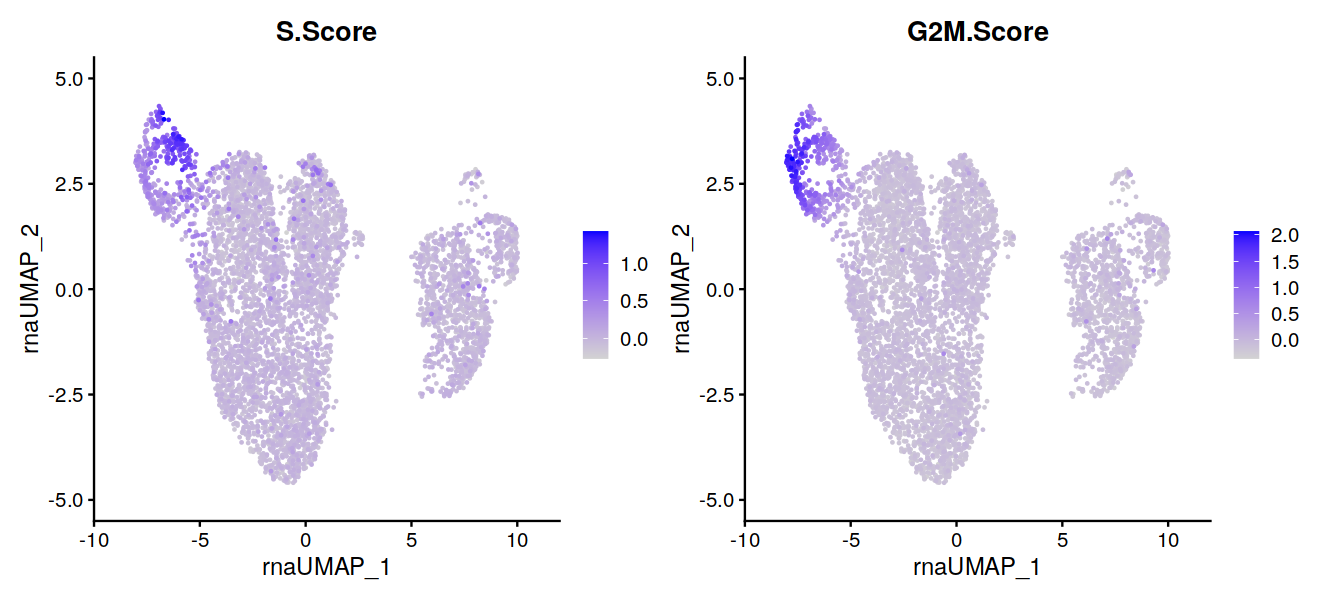

In [116]:
options(repr.plot.width=11, repr.plot.height=5)
FeaturePlot(
    seurat, 
    reduction= "umap.rna", 
    features = c("S.Score", "G2M.Score"), 
    min.cutoff = NA, 
    max.cutoff = NA, 
    ncol = 2, 
    order=T
)

Warning message in PrepDR(object = object, features = features, verbose = verbose):
"The following 28 features requested have not been scaled (running reduction without them): MCM5, MCM2, UNG, MCM6, CDCA7, PRIM1, MLF1IP, RFC2, RPA2, SLBP, UBR7, MSH2, RAD51, CDC45, EXO1, TIPIN, DSCC1, CASP8AP2, CHAF1B, FAM64A, HN1, RANGAP1, NCAPD2, PSRC1, CKAP5, CTCF, G2E3, CBX5"
PC_ 1 
Positive:  CENPF, MKI67, TOP2A, HMGB2, TPX2, DLGAP5, NUSAP1, ANLN, HMMR, GTSE1 
	   BIRC5, CENPE, CKS2, KIF20B, CDK1, CDC20, RRM2, UBE2C, SMC4, HJURP 
	   AURKA, TACC3, NUF2, TUBB4B, KIF11, KIF2C, KIF23, CCNB2, CLSPN, BUB1 
Negative:  POLD3, POLA1, CCNE2, GAS2L3, CDC6, WDR76, LBR, FEN1, UHRF1, PCNA 
	   USP1, BLM, GMNN, DTL, MCM4, GINS2, E2F8, BRIP1, CENPA, ANP32E 
	   RRM1, CDC25C, HELLS, ECT2, RAD51AP1, NASP, ATAD2, CKAP2, CDCA3, AURKB 
PC_ 2 
Positive:  CKS2, DLGAP5, HMMR, CDC20, AURKA, CCNB2, NEK2, BIRC5, CDCA3, CENPA 
	   TPX2, GTSE1, KIF20B, CENPE, UBE2C, CKAP2, NUSAP1, BUB1, NUF2, TUBB4B 
	   CENPF, KIF23, CKS1B, 

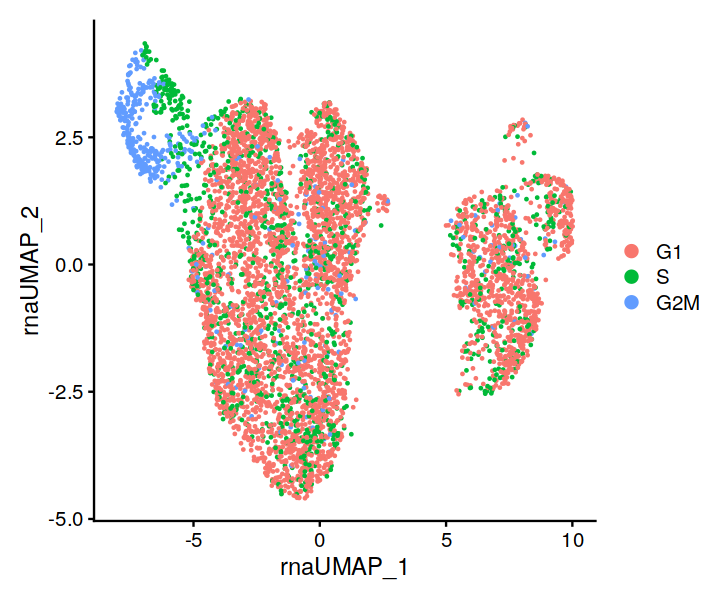

In [117]:
DefaultAssay(seurat) <- "SCT"
seurat_new <- RunPCA(seurat, npcs = 20, features = c(s.genes, g2m.genes))
options(repr.plot.width=6, repr.plot.height=5)
DimPlot(seurat)

# Regress out %mito, #UMIs, S Score

In [118]:
seurat_new <- SCTransform(
  seurat_new,
  assay = 'RNA',
  new.assay.name = 'SCT',
  vars.to.regress = c('percent.mt', 'nFeature_RNA', 'nCount_RNA', 'S.Score', 'G2M.Score'),
  verbose = FALSE,
) %>% RunPCA() %>% RunUMAP(
        dims = 1:40,
        reduction.name = 'umap.rna',
        reduction.key = 'rnaUMAP_',
        verbose=FALSE
      )

PC_ 1 
Positive:  APOE, FN1, FTL, SOD2, MT1X, CRYAB, CDH6, PLIN2, S100A1, G0S2 
	   SERPINE1, RHEX, VCAM1, VGF, CTSB, MGST1, RARRES2, TFPI2, NRXN3, MT1E 
	   FGB, SERPINA1, ABLIM3, GPC6, SLC2A9, GPX3, MSC-AS1, AKR1C3, RRAD, IL32 
Negative:  ERBB4, MECOM, KCNIP4, WFDC2, FAM155A, MAL, BST2, AC019197.1, PDE1A, SFRP1 
	   SKAP1, KITLG, GPNMB, TFAP2B, SNED1, S100A2, ACSL4, TFCP2L1, KRT19, DENND2A 
	   PANTR1, PKHD1, SGIP1, HOXB3, SIM1, LRP1B, SCIN, CSGALNACT1, ARHGEF38, FXYD2 
PC_ 2 
Positive:  FKBP5, SERPINA1, APOE, KCNIP4, MT1X, FTL, MDM2, PKP4, MALAT1, LINC01320 
	   NEAT1, SOD2, ADAMTS9-AS2, ZNF385B, GBE1, PDE4D, RRAD, CPD, LINC01515, ACSM2A 
	   ZIM3, PLIN2, FNIP2, ATP1B1, FTH1, SSBP2, AKR1C3, MSC-AS1, KLF9, ERRFI1 
Negative:  PLCB4, PLAU, KRT19, CCND1, DCBLD2, TUBA1A, CASC19, AKAP12, ADIRF, ARHGAP29 
	   AL355916.1, TMSB10, ARL4C, LGALS1, HMGA2, TPM1, C12orf75, TUBA1B, AC078923.1, FRMD5 
	   THBS1, KRT18, ACTB, NALCN-AS1, AHNAK, S100A6, DCDC2, CCN1, KCNIP1, RRAS2 
PC_ 3 
Positive:  CD

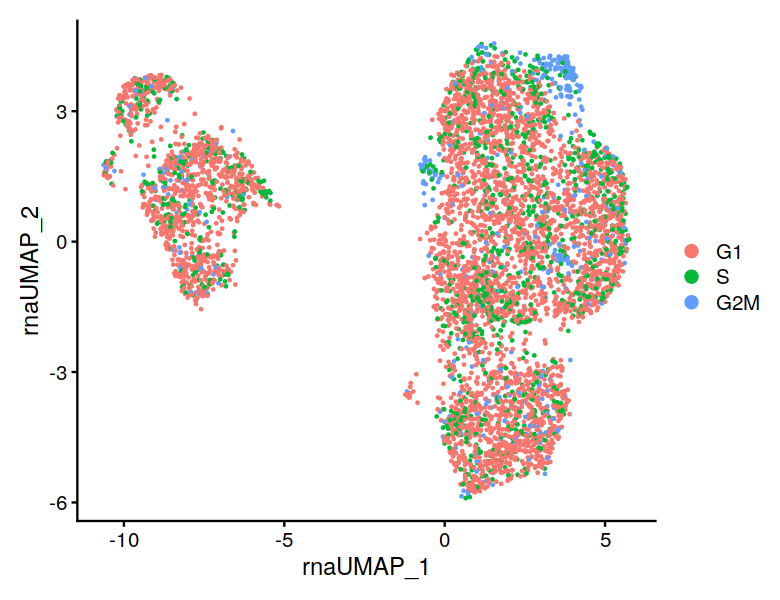

In [119]:
options(repr.plot.width=6.5, repr.plot.height=5)
DimPlot(seurat_new)

## Debug

In [120]:
donor_id = 1
select_donor = (df_soup$assignment == donor_id) & (df_soup$status == 'singlet')
donor_cells = df_soup[select_donor,]$barcode

In [121]:
length(donor_cells)

[1] 2819

In [122]:
head(df_soup)

barcode            status  assignment log_prob_singleton log_prob_doublet
1 AAACCCAAGAGCAGCT-1 singlet 3           -695               -837           
2 AAACCCAAGCCGGAAT-1 doublet 1/2        -6694              -4669           
3 AAACCCAAGCTTAAGA-1 singlet 0          -1141              -1789           
4 AAACCCAAGGCTGTAG-1 singlet 0          -1577              -2450           
5 AAACCCAAGGTTTACC-1 singlet 2          -1469              -1764           
6 AAACCCAAGTGATCGG-1 singlet 2           -677               -795           
  cluster0 cluster1 cluster2 cluster3
1 -2104    -2279    -2433      -695  
2 -8876    -6694    -6876    -11522  
3 -1141    -3152    -2890     -3469  
4 -1577    -4912    -3989     -5245  
5 -3908    -4682    -1469     -5438  
6 -1757    -2186     -677     -2490

# Visualize RNA count distribution

In [123]:
DefaultAssay(seurat) <- "SCT"
top_genes <- sample(VariableFeatures(seurat), 80)
DefaultAssay(seurat) <- "RNA"
df_rna_counts <- as.data.frame(t(seurat[['RNA']]@counts[top_genes, ]))
rownames(df_rna_counts) <- NULL
df_rna_counts$n_rna <- rowSums(df_rna_counts)

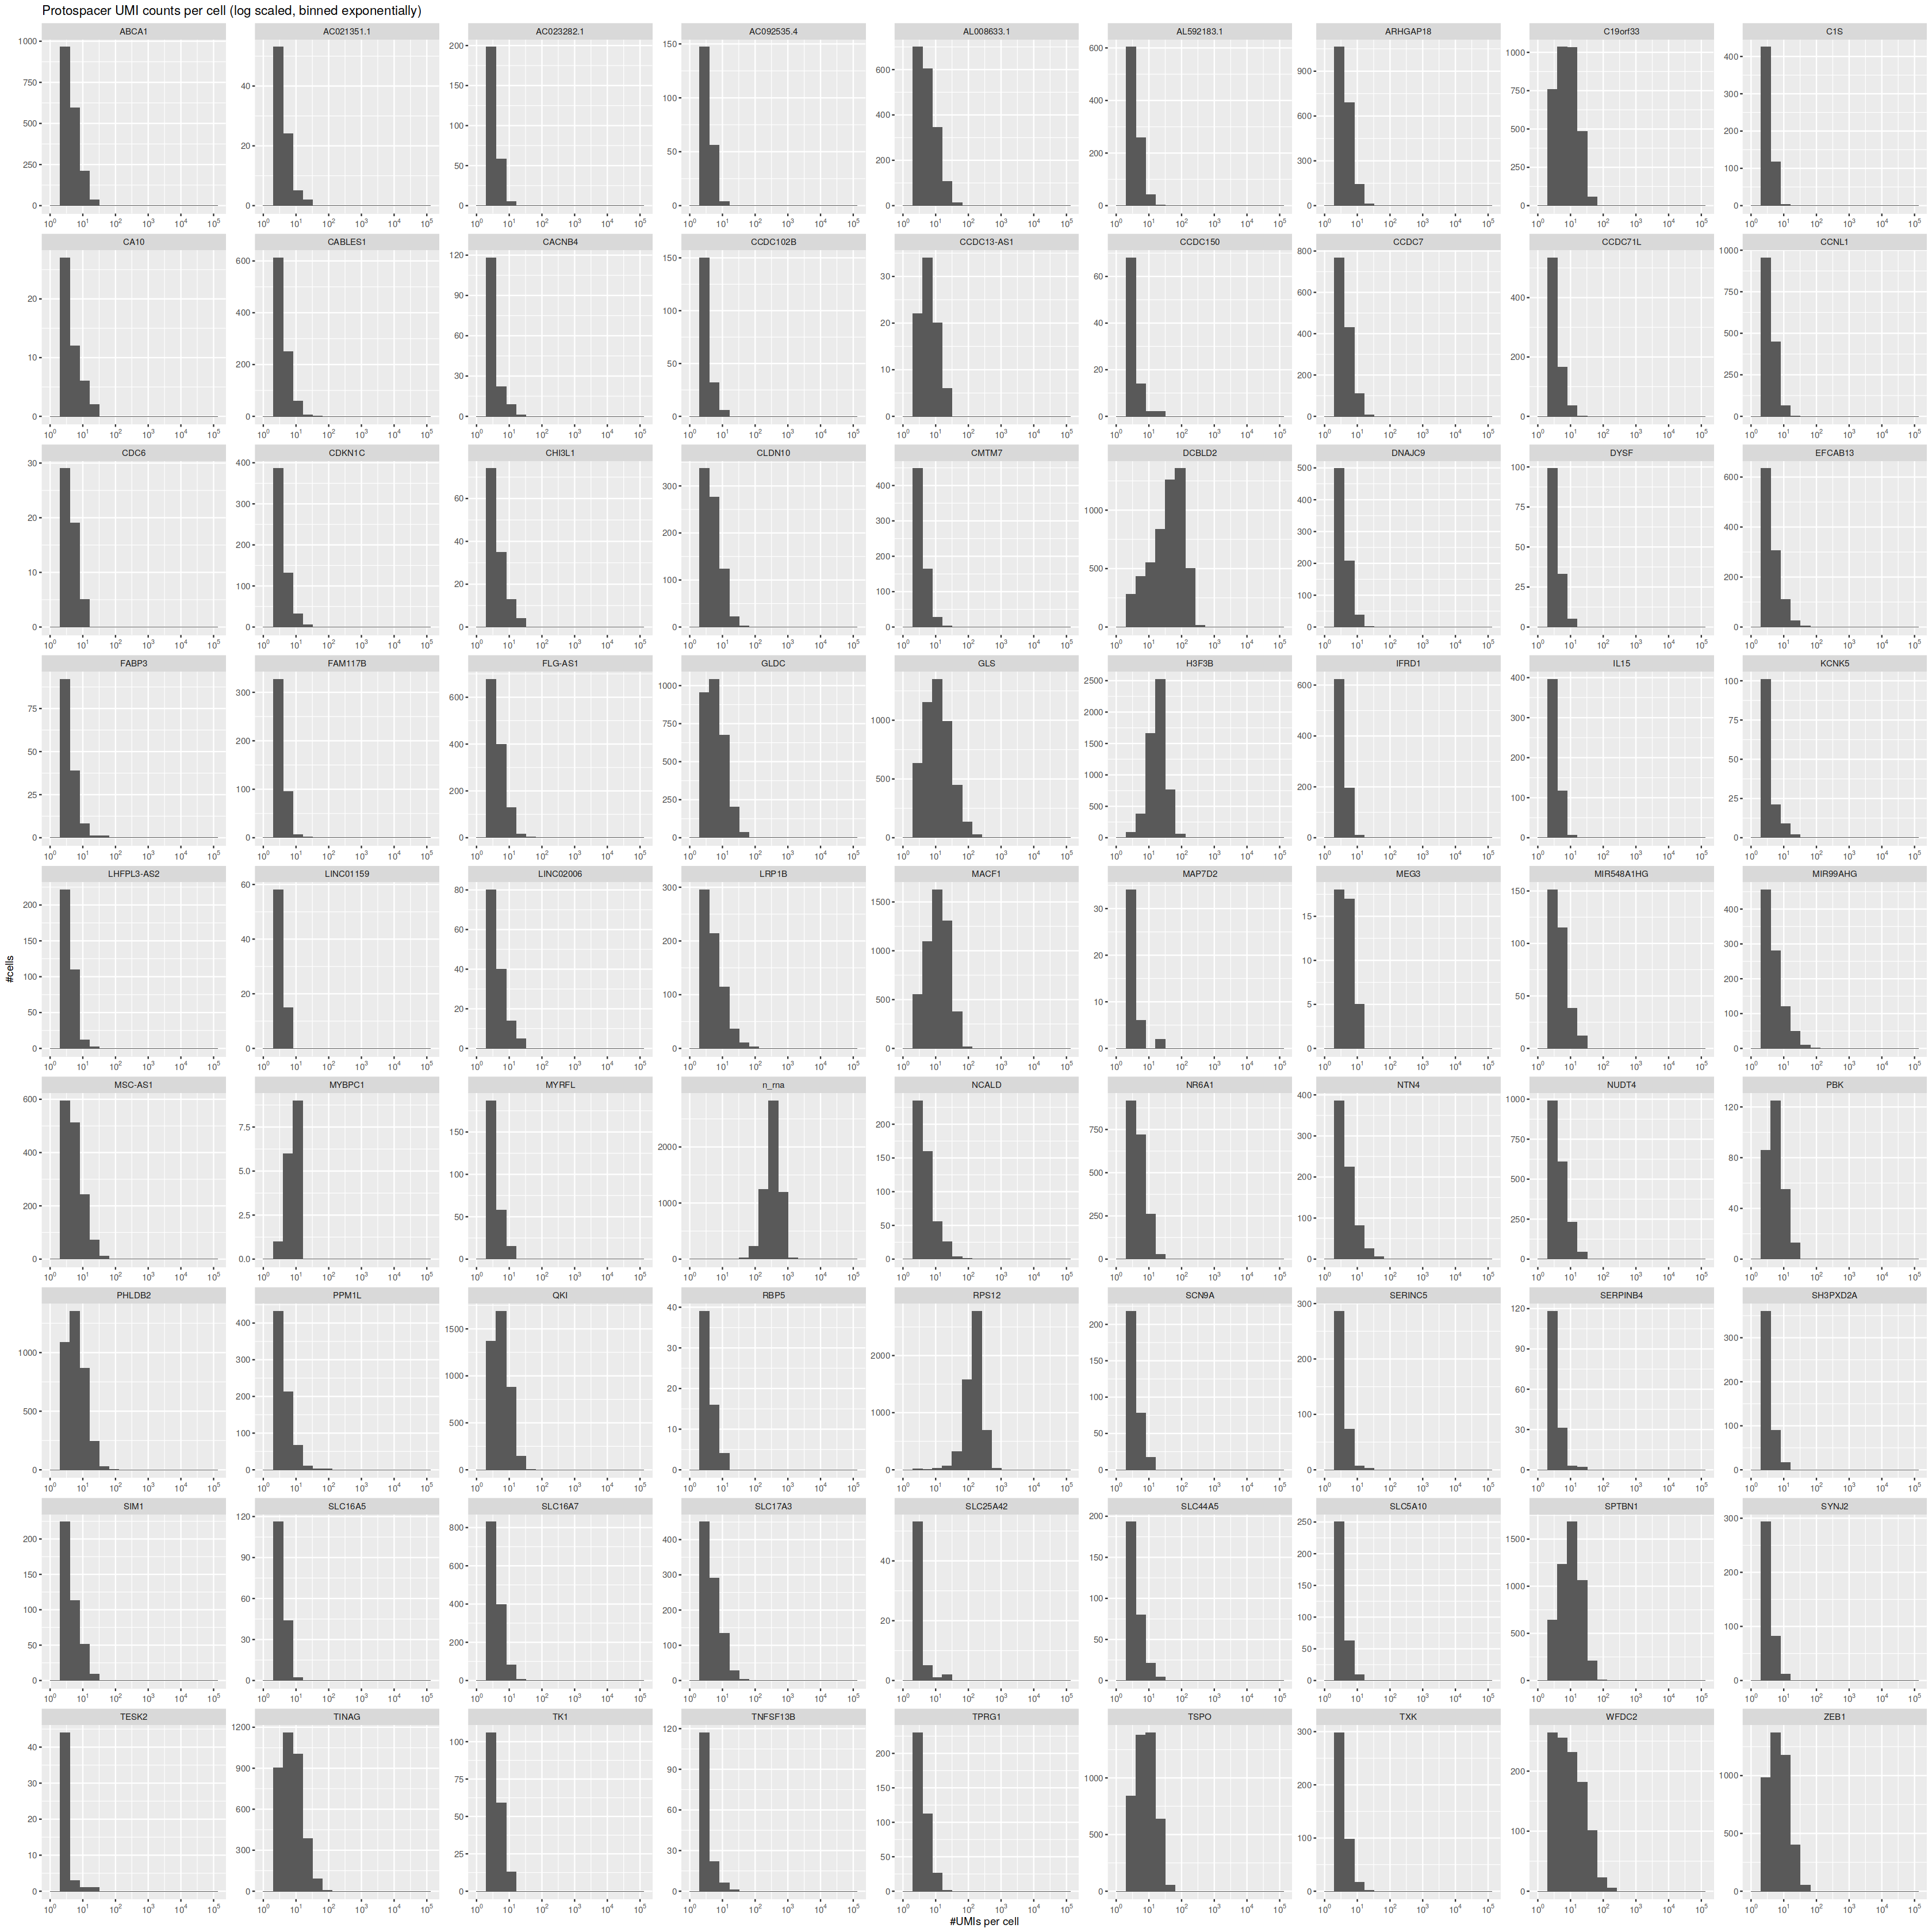

In [124]:
options(repr.plot.width=28, repr.plot.height=20)

data_long <- df_rna_counts %>%                    
  pivot_longer(colnames(df_rna_counts)) %>% 
  as.data.frame()

filter_zeros = data_long$value > 2
data_long <- data_long[filter_zeros,]
bin_breaks <- c(1,2,2*2^(1:16))

ggp1 <- ggplot(data_long, aes(x = value)) +    # Draw each column as histogram
  geom_histogram(breaks=bin_breaks) + 
  scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
  labs(title="Protospacer UMI counts per cell (log scaled, binned exponentially)", x="#UMIs per cell", y="#cells") +
  facet_wrap(~ name, scales = "free", ncol = 9)

ggp2 <- ggplot(data_long, aes(x = value)) +    # Draw each column as histogram
  geom_histogram(bins=100) + 
  labs(title="Protospacer UMI counts per cell", x="#UMIs per cell", y="#cells") +
  facet_wrap(~ name, scales = "free", ncol = 9)


options(repr.plot.width=28, repr.plot.height=28)
ggp1
#ggp2

In [125]:
colnames(head(seurat))

[1] "orig.ident"         "nCount_RNA"         "nFeature_RNA"      
 [4] "nCount_sgRNA"       "nFeature_sgRNA"     "library"           
 [7] "percent.mt"         "PS_call"            "construct_call"    
[10] "target_call"        "nCalled_Constructs" "nPS_calls"         
[13] "nCalled_sgRNA_UMIs" "nCount_SCT"         "nFeature_SCT"      
[16] "status"             "donor"              "S.Score"           
[19] "G2M.Score"          "Phase"              "old.ident"